# **Promotion Effectiveness and Cannibalization Analysis**

## **Preparation**

### **Importing Required Libraries**

In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from scipy.stats import mannwhitneyu
import optuna

In [475]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style
def set_global_plot_style():
    sns.set_theme(style="whitegrid")

    # New global color palette
    custom_palette = ["#009F93", "#DA7635", "#FFD700"]
    sns.set_palette(custom_palette)

    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.3
    })

# Apply the updated style
set_global_plot_style()


### **Loading the Datasets**

In [476]:
# Load the data
sales_df = pd.read_csv("assignment4.1a.csv")
products_df = pd.read_csv("assignment4.1c.csv")
promotion_df = pd.read_csv("PromotionDates.csv")
future_sales_df = pd.read_csv("assignment4.1b.csv") # This is the data for prediction and model validation

After loading the data sets, a quick look at the data sets and their structure.

In [477]:
# Quick look at the few rows of the data
print("\nSales")
print(sales_df.head(3))
print("\nProducts")
print(products_df.head(3))
print("\nPromotion")
print(promotion_df.head(3))
print("\nFuture Sales")
print(future_sales_df.head(3))


Sales
         Date  StoreCode  ProductCode  SalesQuantity
0  2015-01-01          8            9             -1
1  2015-01-01        131            9              1
2  2015-01-01        144            9              2

Products
   ProductCode ProductGroup1  ProductGroup2
0            1             A              5
1            2             A              5
2            3             A              5

Promotion
   Period  StartDate    EndDate
0  Promo1  2/10/2015  2/17/2015
1  Promo2  3/15/2015  3/22/2015
2  Promo3  5/24/2015   6/1/2015

Future Sales
         Date  StoreCode  ProductCode  SalesQuantity
0  2015-08-01          2            9              1
1  2015-08-01          7            9              1
2  2015-08-01         62            9              1


At a first glance, it"s particularly critical to address the date formatting within the Promotion DataFrame. The **StartDate** and **EndDate** columns are currently stored differently than the other datasets, which prevents proper time-based analysis. Therefore, these columns must be parsed and converted into datetime objects.

### **Data Cleaning**

Data cleansing is a fundamental and indispensable phase within the data science workflow, critical for the generation of reliable and valid analytical outcomes. Raw data, frequently characterized by inherent imperfections arising from diverse collection methodologies and human error, necessitates meticulous preprocessing. 

**Formatting the Dates**

Consistent date formatting is crucial in data science to ensure accurate interpretation, enable time-based analysis, facilitate data manipulation like grouping and filtering, create effective visualizations, and guarantee database compatibility.

In [478]:
sales_df["Date"] = pd.to_datetime(sales_df["Date"], format="%Y-%m-%d")
future_sales_df["Date"] = pd.to_datetime(future_sales_df["Date"], format="%Y-%m-%d")
promotion_df["StartDate"] = pd.to_datetime(promotion_df["StartDate"], format="mixed") 
promotion_df["EndDate"] = pd.to_datetime(promotion_df["EndDate"], format="mixed")

In [479]:
print("\nSales")
print(sales_df.head(3))
print("\nPromotion")
print(promotion_df.head(3))
print("\nFuture Sales")
print(future_sales_df.head(3))


Sales
        Date  StoreCode  ProductCode  SalesQuantity
0 2015-01-01          8            9             -1
1 2015-01-01        131            9              1
2 2015-01-01        144            9              2

Promotion
   Period  StartDate    EndDate
0  Promo1 2015-02-10 2015-02-17
1  Promo2 2015-03-15 2015-03-22
2  Promo3 2015-05-24 2015-06-01

Future Sales
        Date  StoreCode  ProductCode  SalesQuantity
0 2015-08-01          2            9              1
1 2015-08-01          7            9              1
2 2015-08-01         62            9              1


**Checking for Missing Values**

The identification and management of missing values is a crucial aspect of data preprocessing. The presence of such values can introduce bias and compromise the integrity of subsequent analyses.

In [480]:
# Check for missing values
print("Missing Values:\n")
print(sales_df.isnull().sum())
print("\n")
print(products_df.isnull().sum())
print("\n")
print(promotion_df.isnull().sum())
print("\n")
print(future_sales_df.isnull().sum())

Missing Values:

Date             0
StoreCode        0
ProductCode      0
SalesQuantity    0
dtype: int64


ProductCode      0
ProductGroup1    0
ProductGroup2    0
dtype: int64


Period       0
StartDate    0
EndDate      0
dtype: int64


Date             0
StoreCode        0
ProductCode      0
SalesQuantity    0
dtype: int64


After checking, no missing value found.

In addition to null values, we can also check if there are 0 or negative values in numeric columns that might a problem for analysis in the future. A generic function is a suitable option.

In [481]:
# Function to count 0 and negative values in numeric columns
def count_zero_or_negative_values(df, dataset_name):
    zero_or_negative_counts = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):  # Check if the column is numeric
            zero_or_negative_counts[column] = ((df[column] <= 0)).sum()
    return {dataset_name: zero_or_negative_counts}

# Datasets
datasets = {
    "Sales": sales_df,
    "Products": products_df,
    "Promotion": promotion_df,
    "Future Sales": future_sales_df
}

# Count 0 and negative values in numeric columns
results = {}
for name, df in datasets.items():
    results.update(count_zero_or_negative_values(df, name))

# Print the results
for dataset, zero_or_negative_counts in results.items():
    print(f"Results for {dataset}:")
    for column, count in zero_or_negative_counts.items():
        print(f"  {column}: {count} rows with 0 or negative values")
    print()

Results for Sales:
  StoreCode: 0 rows with 0 or negative values
  ProductCode: 0 rows with 0 or negative values
  SalesQuantity: 600659 rows with 0 or negative values

Results for Products:
  ProductCode: 0 rows with 0 or negative values
  ProductGroup2: 0 rows with 0 or negative values

Results for Promotion:

Results for Future Sales:
  StoreCode: 0 rows with 0 or negative values
  ProductCode: 0 rows with 0 or negative values
  SalesQuantity: 343245 rows with 0 or negative values



There are no 0 or negative values in datasets except **SalesQuantity**. As mentioned in the case study document, negative values represent product returns and 0 values can be assumed as there is no sales for that product at that store at that day.

**Checking Data Types**

Verification of data types ensures that each variable"s data conforms to its intended type (e.g., numeric, categorical, date), preventing errors in computation and analysis.

In [482]:
# Check for data types
print("Data Types:\n")
print(sales_df.dtypes)
print("\n")
print(products_df.dtypes)
print("\n")
print(promotion_df.dtypes)
print("\n")
print(future_sales_df.dtypes)

Data Types:

Date             datetime64[ns]
StoreCode                 int64
ProductCode               int64
SalesQuantity             int64
dtype: object


ProductCode       int64
ProductGroup1    object
ProductGroup2     int64
dtype: object


Period               object
StartDate    datetime64[ns]
EndDate      datetime64[ns]
dtype: object


Date             datetime64[ns]
StoreCode                 int64
ProductCode               int64
SalesQuantity             int64
dtype: object


The data types are correct and there is no missing values within data sets. Hence, the datasets are in good shape. Since the minus values in **SalesQuantity** columns are returns, they will be treated as such for the rest of the analysis.

Checking for Outliers

In [483]:
sales_df.describe() # Summary statistics for the dataset to have a quick look at the data to see if there are obvious outliers

,Date,StoreCode,ProductCode,SalesQuantity
count,1873618,1.873618e+06,1.873618e+06,1.873618e+06
mean,2015-04-14 10:09:35.587126528,1.711288e+02,1.663533e+02,2.246632e+00
min,2015-01-01 00:00:00,1.000000e+00,1.000000e+00,-6.000000e+01
25%,2015-02-23 00:00:00,8.100000e+01,1.050000e+02,0.000000e+00
50%,2015-04-13 00:00:00,1.700000e+02,1.730000e+02,1.000000e+00
75%,2015-06-03 00:00:00,2.640000e+02,2.190000e+02,2.000000e+00
max,2015-07-31 00:00:00,3.400000e+02,3.170000e+02,9.120000e+02
std,NaN,1.014606e+02,7.773282e+01,5.028994e+00


In [484]:
print(sales_df.describe()) # Summary statistics for the dataset to have a quick look before modeling

                                Date     StoreCode   ProductCode  \
count                        1873618  1.873618e+06  1.873618e+06   
mean   2015-04-14 10:09:35.587126528  1.711288e+02  1.663533e+02   
min              2015-01-01 00:00:00  1.000000e+00  1.000000e+00   
25%              2015-02-23 00:00:00  8.100000e+01  1.050000e+02   
50%              2015-04-13 00:00:00  1.700000e+02  1.730000e+02   
75%              2015-06-03 00:00:00  2.640000e+02  2.190000e+02   
max              2015-07-31 00:00:00  3.400000e+02  3.170000e+02   
std                              NaN  1.014606e+02  7.773282e+01   

       SalesQuantity  
count   1.873618e+06  
mean    2.246632e+00  
min    -6.000000e+01  
25%     0.000000e+00  
50%     1.000000e+00  
75%     2.000000e+00  
max     9.120000e+02  
std     5.028994e+00  


Descriptive analysis shows a some potential red flags. These red flags and methods to address them are as follows:

* High standard deviations relative to the means suggest the presence of outliers in Sales Quantity and Net Sales. As it is seen **SalesQuantity** and **Net_Sales** distributions are highly skewed, with most values around 1-2 units, but with extreme maximums (912). Therefore, we need to deal with the outliers.
    - Outliers will be capped to minimize the disproportionate influence of rare extreme values while preserving high, valid sales activity. Details of this decision will be explained later.

* While returns are relatively rare (mean = 0.01), some transactions involved high return quantities (maximum = 60), which can impact net sales and product performance analysis.
    - Returns are kept as a separate variable for inclusion as a feature or for analysis on the effectiveness of promotions and product performance during and after promotional periods.


* Over 50% of transactions involve sales of just one unit or none. This dominance of low sales values increases the risk of models underestimating higher sales scenarios and promotions" true effects.
    - The impact of low and zero sales will be carefully considered in modeling and analysis, ensuring promotions are evaluated fairly without distortion from inactive periods.


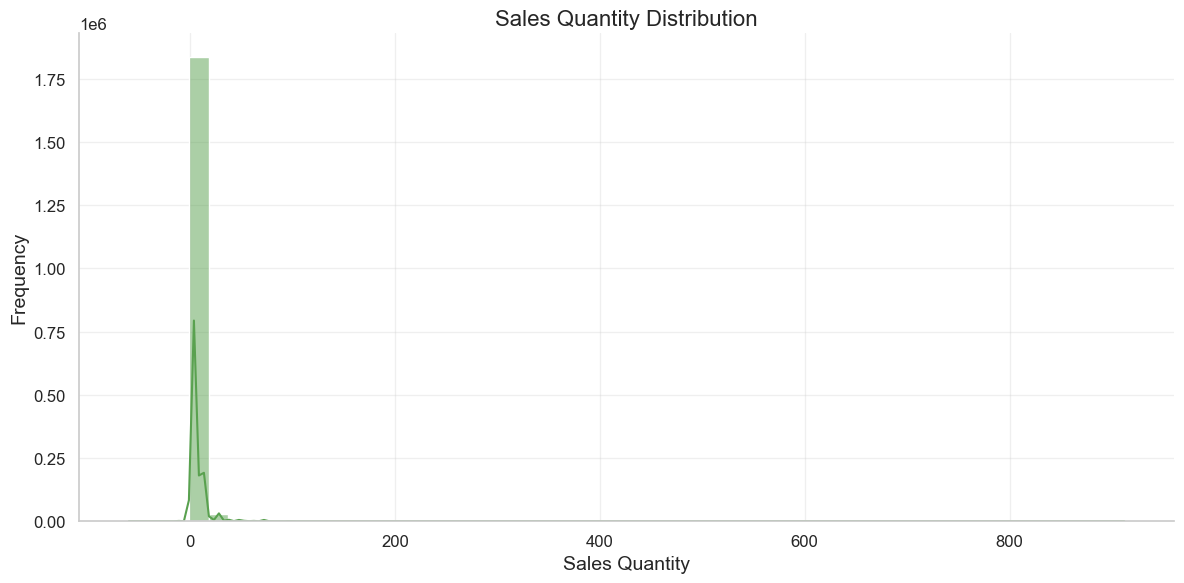

In [485]:
# Check the sales distribution
plt.figure(figsize=(12, 6))
sns.histplot(
    data=sales_df, 
    x="SalesQuantity", 
    bins=50, 
    kde=True, 
    color="#59A14F"  
)
plt.title("Sales Quantity Distribution", fontsize=16)
plt.xlabel("Sales Quantity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

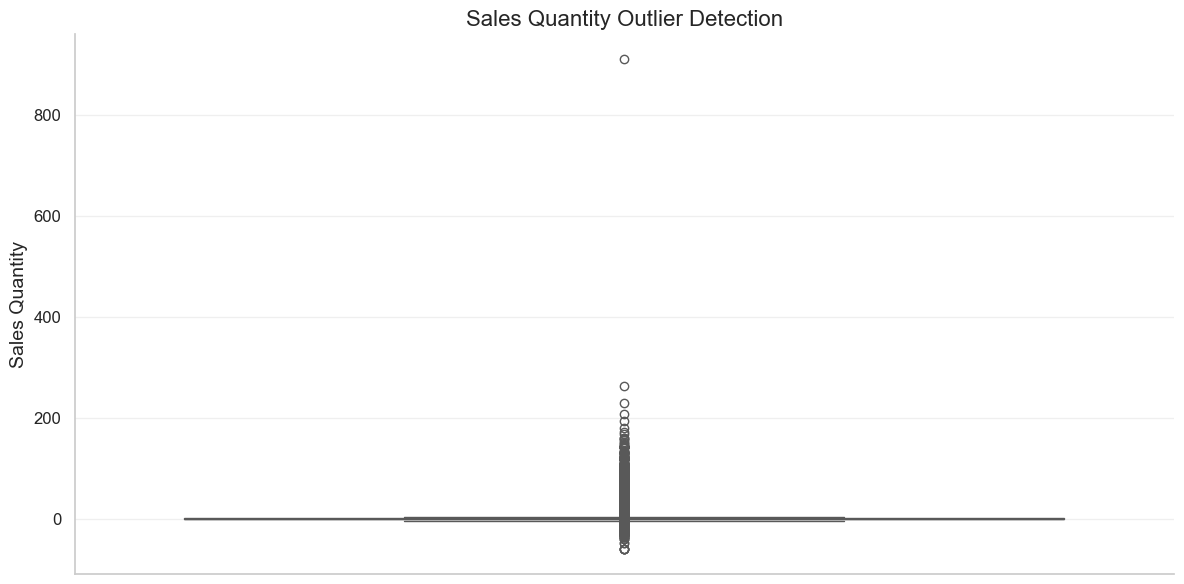

In [486]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    y=sales_df["SalesQuantity"],
    color="#B07AA1"  
)
plt.title("Sales Quantity Outlier Detection", fontsize=16)
plt.ylabel("Sales Quantity", fontsize=14)
plt.xlabel("")  
plt.tight_layout()
plt.show()

In [487]:
extreme_outliers = sales_df[sales_df["SalesQuantity"] > 200]
print(extreme_outliers)

              Date  StoreCode  ProductCode  SalesQuantity
848417  2015-03-29         62          168            209
850128  2015-03-30        117          168            264
1317013 2015-02-16        135          218            230
1354290 2015-03-21        256          218            912


We observe that the SalesQuantity variable exhibited a highly skewed distribution, with most transactions involving small quantities (typically between 0 and 10 units) as it is seen on the graphs. This observation is highly common in sales data. However, there are a few extreme values, including a single observation with a sales quantity of 913 units, which was substantially higher than the rest of the data. The next highest value was 264, while the majority of sales quantities were well below 100.

Such extreme outliers can heavily distort both statistical analysis and modeling. To address this, we evaluated two common approaches:

* Logarithmic Transformation of the SalesQuantity variable to normalize the distribution.
* Outlier Capping (Winsorization) to limit the impact of extreme values while preserving the original scale of sales quantities.

After careful consideration, we chose the outlier capping approach because the client requires forecasting actual sales quantities, which are easier to interpret and compare when left on their original scale. Applying a log transformation would require reversing the transformation (exponential) during interpretation, which could introduce bias and complexity, especially in skewed distributions. Also, the business stakeholders expect to see sales results in units sold, making it important to keep the modeling and output in the original quantity scale.

In [488]:
# Check key percentiles to decide the cap for outliers
sales_df["SalesQuantity"].describe(percentiles=[0.90, 0.95, 0.99])

count    1.873618e+06
mean     2.246632e+00
std      5.028994e+00
min     -6.000000e+01
50%      1.000000e+00
90%      4.000000e+00
95%      1.200000e+01
99%      2.400000e+01
max      9.120000e+02
Name: SalesQuantity, dtype: float64

We observe that 99% of all sales are below 24 units, while the maximum recorded value reaches 912 units, which is nearly 40 times larger than the 99th percentile.

These findings indicate that:

- Sales beyond 24 units are extremely rare, representing less than 1% of total sales.

- The presence of such extreme values (up to 912 units) creates a highly skewed distribution, which:
    - Inflates the mean (2.24 units) relative to the median (1 unit).
    - Compresses visualizations like boxplots, making typical sales patterns difficult to see.
    - Risks causing predictive models to overfit on these rare extreme cases, leading to poorer performance on regular, day-to-day sales.


These extreme values heavily skew the data distribution, leading to misleading averages and incorrect interpretations. Capping ensures that the analysis focuses on typical, repeatable sales behaviors rather than rare anomalies.

To mitigate the impact of extreme outliers, we capped SalesQuantity at 50 units, slightly above the 99th percentile, ensuring stable model performance without losing significant business insights. 50 unit is chosen because capping at 24 units would have been too restrictive and might have cut off valid high sales events, such as rare but real bulk purchases.

This preprocessing step ensures the models and insights reflect typical sales patterns, reduce distortion from rare anomalies, and support more stable, actionable recommendations for the business



In [489]:
cap_value = 50
sales_df["SalesQuantity_Capped"] = sales_df["SalesQuantity"].clip(lower=0, upper=cap_value)

# **Part-A: Past Data Analysis & Model Development**

## **Data Preparation**

Since each product in sales database has a **ProductCode**, we can merge it with the product hierarchy dataset to label products according to the product categories.

In [490]:
sales_df.head(10)

,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped
0,2015-01-01,8,9,-1,0
1,2015-01-01,131,9,1,1
2,2015-01-01,144,9,2,2
3,2015-01-01,203,9,2,2
4,2015-01-01,256,9,0,0
5,2015-01-01,273,9,1,1
6,2015-01-02,12,9,0,0
7,2015-01-02,52,9,1,1
8,2015-01-02,65,9,1,1
9,2015-01-02,118,9,1,1


In [491]:
sales_df = sales_df.merge(products_df, on="ProductCode", how="left")
print(sales_df.head(10))

        Date  StoreCode  ProductCode  SalesQuantity  SalesQuantity_Capped  \
0 2015-01-01          8            9             -1                     0   
1 2015-01-01        131            9              1                     1   
2 2015-01-01        144            9              2                     2   
3 2015-01-01        203            9              2                     2   
4 2015-01-01        256            9              0                     0   
5 2015-01-01        273            9              1                     1   
6 2015-01-02         12            9              0                     0   
7 2015-01-02         52            9              1                     1   
8 2015-01-02         65            9              1                     1   
9 2015-01-02        118            9              1                     1   

  ProductGroup1  ProductGroup2  
0             H             15  
1             H             15  
2             H             15  
3             H     

After merging, we need to be sure if there is still no missing values.

In [492]:
print("Missing Values:\n")
print(sales_df.isnull().sum())

Missing Values:

Date                    0
StoreCode               0
ProductCode             0
SalesQuantity           0
SalesQuantity_Capped    0
ProductGroup1           0
ProductGroup2           0
dtype: int64


To calculate the sales during promotion, we need to flag sale dates accordingly.

In [493]:
# Create a column to indicate if a product sold during promotion
sales_df["IsPromotion"] = 0 # Default: no promotion

# Assign 1 if the sale date falls within a promo period
for _, row in promotion_df.iterrows():
    sales_df.loc[(sales_df["Date"] >= row["StartDate"]) & (sales_df["Date"] <= row["EndDate"]), "IsPromotion"] = 1

sales_df.head()

,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped,ProductGroup1,ProductGroup2,IsPromotion
0,2015-01-01,8,9,-1,0,H,15,0
1,2015-01-01,131,9,1,1,H,15,0
2,2015-01-01,144,9,2,2,H,15,0
3,2015-01-01,203,9,2,2,H,15,0
4,2015-01-01,256,9,0,0,H,15,0


To address minus values in sales data, we can create a seperate column for returns and track them. In addition, we can add another column for net sales to keep track of actual sold products. So that we can analyse total sales (**SalesQuantity**), returns (**Returns**) and actual sold items (**Net_Sales**).

In [494]:
sales_df["Returns"] = sales_df["SalesQuantity"].apply(lambda x: abs(x) if x < 0 else 0) # A column for returns
sales_df["Net_Sales"] = sales_df["SalesQuantity"].apply(lambda x: x if x > 0 else 0) # A column for net sales

sales_df.head()

,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped,ProductGroup1,ProductGroup2,IsPromotion,Returns,Net_Sales
0,2015-01-01,8,9,-1,0,H,15,0,1,0
1,2015-01-01,131,9,1,1,H,15,0,0,1
2,2015-01-01,144,9,2,2,H,15,0,0,2
3,2015-01-01,203,9,2,2,H,15,0,0,2
4,2015-01-01,256,9,0,0,H,15,0,0,0


In [495]:
net_sales_cap = 50 # It is consistent with the capped sales quantity
sales_df["Net_Sales_Capped"] = sales_df["Net_Sales"].clip(upper=net_sales_cap)

For further analysis, it is better to add month and week columns as well. It is important to mention that the data for sales starts midweek, Thursday. Since we do not have the data for the rest of days of that week, 29/12/2014, we can assume that the total sales number is what we have in hand. Instead of week periods, we can create a column with week numbers for respective year.

In [496]:
sales_df["Week"] = sales_df["Date"].dt.isocalendar().week
sales_df["Year"] = sales_df["Date"].dt.isocalendar().year
sales_df["FormattedWeek"] = sales_df["Year"].astype(str) + "- W" + sales_df["Week"].astype(str).str.zfill(2) # Formatted week number to have Year-Week format for visualizations
sales_df["Month"] = sales_df["Date"].dt.to_period("M")
sales_df

,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped,ProductGroup1,ProductGroup2,IsPromotion,Returns,Net_Sales,Net_Sales_Capped,Week,Year,FormattedWeek,Month
0,2015-01-01,8,9,-1,0,H,15,0,1,0,0,1,2015,2015- W01,2015-01
1,2015-01-01,131,9,1,1,H,15,0,0,1,1,1,2015,2015- W01,2015-01
2,2015-01-01,144,9,2,2,H,15,0,0,2,2,1,2015,2015- W01,2015-01
3,2015-01-01,203,9,2,2,H,15,0,0,2,2,1,2015,2015- W01,2015-01
4,2015-01-01,256,9,0,0,H,15,0,0,0,0,1,2015,2015- W01,2015-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873613,2015-07-30,292,315,0,0,D,16,0,0,0,0,31,2015,2015- W31,2015-07
1873614,2015-07-31,12,315,1,1,D,16,0,0,1,1,31,2015,2015- W31,2015-07
1873615,2015-07-31,104,315,1,1,D,16,0,0,1,1,31,2015,2015- W31,2015-07
1873616,2015-07-31,261,315,1,1,D,16,0,0,1,1,31,2015,2015- W31,2015-07


### **Clustering Products & Stores: Fast, Medium, Slow**


The case study indicates that stores and products needs to be categorized into three distinct clusters. According to the case study instructions, clustering is required to be based on average weekly sales during non-promotion periods.

* **Fast items/stores:** higher average weekly sale per store during non-promotion periods

* **Slow items/stores:** lower weekly average sale per store during non-promotion periods

* **Medium items/stores:** the rest of the stores/products that are not in the first two clusters

While various clustering methods exist, including manual thresholding and machine learning algorithms (such as k-means, Gaussian Mixture Models (GMM), or BIRCH), the client has provided a business-defined clustering logic. Machine learning algorithms performs better at uncovering inherent data patterns and offer dynamic, data-driven segmentation. However, manual clustering provides straightforward interpretability without the need for hyperparameter tuning.

In this instance, the client"s logic aligns with a quantile-based segmentation approach. This involves establishing predefined thresholds to create Fast, Medium, and Slow categories based on average weekly sales during non-promotion periods. This approach offers a clear and interpretable method for categorizing the stores and products as required.

Although the dataset contains both SalesQuantity and Net_Sales, which was added later, it is important to clarify that:

- SalesQuantity reflects the total number of units sold.
- Net_Sales is the result of sales quantity minus returns.

To accurately classify products and stores by their typical sales activity — that is, the volume of goods sold — the clustering is performed using SalesQuantity_Capped. This approach ensures:

- Clusters reflect the true selling behavior of products and stores without directly penalizing them for return behavior.
- Products that sell large quantities but may experience higher returns are still identified as Fast movers based on their gross sales, which is more aligned with business expectations for clustering.
- Returns are handled separately in the analysis and do not distort the classification of product or store performance.


Clustering Products

In [497]:
# Filter sales data outside promotion periods
non_promo_sales = sales_df[sales_df["IsPromotion"] == 0].copy()

# As stated by the case study, this ensures weekly sales are measured per product per store
weekly_sales = non_promo_sales.groupby(["ProductCode", "StoreCode", "Year", "Week"])["SalesQuantity_Capped"].sum().reset_index() 

# Calculate the average weekly sales per product (aggregated across all stores)
avg_weekly_sales = weekly_sales.groupby("ProductCode")["SalesQuantity_Capped"].mean().reset_index() # Group by product

# Compute tertiles (33rd & 66th percentiles) for category thresholds
tertiles = avg_weekly_sales["SalesQuantity_Capped"].quantile([0.33, 0.66])

avg_weekly_sales["Product_Category"] = pd.cut( # Segment the data into 3 categories based on the thresholds
    avg_weekly_sales["SalesQuantity_Capped"],
    # -np.inf bin puts everything below the 33rd percentile in Slow category
    # np.inf bin puts everything above the 66th percentile in Fast category
    # tertiles[0.33] to tertiles[0.66] represent the Medium category
    bins=[-np.inf, tertiles[0.33], tertiles[0.66], np.inf], 
    labels=["Slow", "Medium", "Fast"])

# Merge back with the main sales dataset
sales_df = sales_df.merge(avg_weekly_sales[["ProductCode", "Product_Category"]], on="ProductCode", how="left")
sales_df.head()


,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped,ProductGroup1,ProductGroup2,IsPromotion,Returns,Net_Sales,Net_Sales_Capped,Week,Year,FormattedWeek,Month,Product_Category
0,2015-01-01,8,9,-1,0,H,15,0,1,0,0,1,2015,2015- W01,2015-01,Slow
1,2015-01-01,131,9,1,1,H,15,0,0,1,1,1,2015,2015- W01,2015-01,Slow
2,2015-01-01,144,9,2,2,H,15,0,0,2,2,1,2015,2015- W01,2015-01,Slow
3,2015-01-01,203,9,2,2,H,15,0,0,2,2,1,2015,2015- W01,2015-01,Slow
4,2015-01-01,256,9,0,0,H,15,0,0,0,0,1,2015,2015- W01,2015-01,Slow


Clustering Stores

In [498]:
# Total sales per store (non-promo periods)
weekly_sales_stores = non_promo_sales.groupby(["StoreCode", "Year", "Week"])["SalesQuantity_Capped"].sum().reset_index()

# Compute average weekly sales per store
avg_weekly_sales_stores = weekly_sales_stores.groupby("StoreCode")["SalesQuantity_Capped"].mean().reset_index()

# Compute tertiles (33rd & 66th percentiles) for store classification
tertiles = avg_weekly_sales_stores["SalesQuantity_Capped"].quantile([0.33, 0.66])

# Assign store categories (Slow, Medium, Fast) based on tertiles
avg_weekly_sales_stores["Store_Category"] = pd.cut(
    avg_weekly_sales_stores["SalesQuantity_Capped"],
    bins=[-np.inf, tertiles[0.33], tertiles[0.66], np.inf], # Defines the bins just like the product categories above
    labels=["Slow", "Medium", "Fast"]
)
# Merge back into the main dataset
sales_df = sales_df.merge(avg_weekly_sales_stores[["StoreCode", "Store_Category"]], on="StoreCode", how="left")
sales_df.head()

,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped,ProductGroup1,ProductGroup2,IsPromotion,Returns,Net_Sales,Net_Sales_Capped,Week,Year,FormattedWeek,Month,Product_Category,Store_Category
0,2015-01-01,8,9,-1,0,H,15,0,1,0,0,1,2015,2015- W01,2015-01,Slow,Medium
1,2015-01-01,131,9,1,1,H,15,0,0,1,1,1,2015,2015- W01,2015-01,Slow,Fast
2,2015-01-01,144,9,2,2,H,15,0,0,2,2,1,2015,2015- W01,2015-01,Slow,Slow
3,2015-01-01,203,9,2,2,H,15,0,0,2,2,1,2015,2015- W01,2015-01,Slow,Slow
4,2015-01-01,256,9,0,0,H,15,0,0,0,0,1,2015,2015- W01,2015-01,Slow,Fast


In [499]:
# Check if there is any missing value
print("Missing Values:\n")
print(sales_df.isnull().sum())

Missing Values:

Date                    0
StoreCode               0
ProductCode             0
SalesQuantity           0
SalesQuantity_Capped    0
ProductGroup1           0
ProductGroup2           0
IsPromotion             0
Returns                 0
Net_Sales               0
Net_Sales_Capped        0
Week                    0
Year                    0
FormattedWeek           0
Month                   0
Product_Category        1
Store_Category          0
dtype: int64


Per analysis, we see that there is a missing value in Prodoct_Category. To deal with it, we need to locate it.

In [500]:
missing = sales_df[sales_df["Product_Category"].isnull()]
print(missing)

              Date  StoreCode  ProductCode  SalesQuantity  \
1182790 2015-02-16          3          261              0   

         SalesQuantity_Capped ProductGroup1  ProductGroup2  IsPromotion  \
1182790                     0             F             27            1   

         Returns  Net_Sales  Net_Sales_Capped  Week  Year FormattedWeek  \
1182790        0          0                 0     8  2015     2015- W08   

           Month Product_Category Store_Category  
1182790  2015-02              NaN           Slow  


The output shows that missing product has no return or sales so it will not affect the analysis. We can safely remove this observation from the dataset.

In [501]:
sales_df.dropna(subset=["Product_Category"], inplace=True)
print("Missing Values:\n") # Check if there is any missing value
print(sales_df.isnull().sum())

Missing Values:

Date                    0
StoreCode               0
ProductCode             0
SalesQuantity           0
SalesQuantity_Capped    0
ProductGroup1           0
ProductGroup2           0
IsPromotion             0
Returns                 0
Net_Sales               0
Net_Sales_Capped        0
Week                    0
Year                    0
FormattedWeek           0
Month                   0
Product_Category        0
Store_Category          0
dtype: int64


**Logic Behind the Clustering Criteria for Products and Items**

As mentioned earlier, quantiles provide a simple, interpretable way to categorize items and stores based on their sales performance during non-promotion periods. The rule for categorizing the stores and products is given by the case study. To categorize items and stores based on their sales performance during non-promotion periods, as per the case study"s request, we employed a quantile-based approach using tertiles. Tertiles, which divide a dataset into three equal parts, were chosen specifically because the case study indicated three distinct categories: Slow, Medium, and Fast.

Tertiles are statistical divisions that split a dataset into three equal parts, each containing approximately one-third of the data. The 33rd percentile marks the boundary between the lowest third (Slow) and the middle third (Medium), while the 66th percentile marks the boundary between the middle third (Medium) and the highest third (Fast). This method ensures a balanced distribution across the three categories, reflecting the natural sales performance of items and stores.

Our selection of the quantile-based approach, specifically tertiles, was driven by several factors
* The case study"s directive to categorize the items and stores should be grouped based on their average weekly sales during non-promotion periods, which provide clear thresholds for Slow, Medium, and Fast categories

* Tertiles offer intuitive thresholds (33rd and 66th percentiles), making the categorization process easily understandable for both technical and non-technical stakeholders.

* This approach is flexible and can be applied to different datasets and contexts. For example, if the sales distribution changes over time, the tertile thresholds can be recalculated to reflect the new distribution.

After calculating the average weekly sales during these non-promotion periods for each product-store combination and stores, we use tertiles to divide the items into three groups: **Slow Items**  (below the 33rd percentile), **Medium Items** (between the 33rd and 66th percentiles), and **Fast Items** (above the 66th percentile). This approach ensures a balanced distribution of items based on their natural sales performance.

## **Exploratory Analysis**

This section will provide insights about the dataset before modeling. It will be beneficial to check the distribution of variables to spot unexpected patterns or data quality issues. Also, it will provide us information about how item groups are behaving. Due to the structure of the dataset, this analysis will have some limitations because the dataset has limited number of features and many of these features are categorical. In addition, the key data, sales, is naturally skewed, so standard correlation analysis can be misleading. But, possible complex relationships will be handled directly with the model.

### **Target (Dependent) Variable Selection**

The ultimate goal of this study is to evaluate the effectiveness of promotions in driving revenue and to understand the broader impact of promotional strategies on total business performance. In this context, Net Sales serves as the most appropriate and business-relevant measure of success, as it directly reflects the actual monetary value generated from product sales after accounting for discounts, returns, and other adjustments.

While sales quantity (units sold) is often useful in operational contexts, such as inventory planning, our focus is on revenue optimization, where the financial outcome of promotional actions is significant. Net Sales captures the financial impact, making it the ideal target variable to assess both promotional uplift and cannibalization in revenue terms, which aligns directly with the strategic objectives of the marketing and commercial teams.

Specifically, we will use Net_Sales_Capped in order to mitigate the outliers.This approach ensures that the models focus on learning from the normal sales patterns that represent the majority of the business, while preventing extreme cases from dominating the model’s coefficients or tree splits.

### **Independent Variable Selection**

To accurately model sales behavior and understand promotion effectiveness, we engineered a set of independent variables that capture the key drivers of sales variation. These variables were selected based on both business logic and data-driven insights and can be grouped into several categories:


1. Promotion-related variables:
    - IsPromotion: Indicates whether a product is on promotion during a given period. This is the primary variable to measure direct promotion impact.
    - Cumulative_Promotions: Tracks the total number of past promotions for a product, capturing long-term promotional fatigue or saturation effects.
    - Interaction terms (such as Promotion_FastProduct, Promotion_ProductGroup_Combo_X): These capture nuanced effects, such as how different product types or combinations react under promotion.
2. Product characteristics:
    - Product_Category (Fast, Medium, Slow): Reflects inherent product velocity, recognizing that fast-moving items typically behave differently under promotion than slower ones.
    - ProductGroup_Combo (combinations of ProductGroup1 and ProductGroup2): Allows us to capture relationships within product groupings, which is essential for analyzing cannibalization, as similar products may compete with one another during promotions.
3. Store characteristics:
    - Store_Category (Fast, Medium, Slow): Recognizes that store performance varies and that promotions may have different impacts across store types.
4. Temporal variables:
    - Days_Since_Start: Controls for long-term trends or seasonality over the course of the dataset.
    - Is_Weekend: Accounts for predictable weekly seasonality, with weekends often having different sales dynamics.
    - Day_of_Week dummies: Added to capture monthly seasonality and weekday effects, helping the models to adjust for systematic differences across the calendar.


### **Univariate Analysis**

The univariate analysis provides insights into the general structure of the dataset, focusing on the distributions of sales, returns, and the distribution of product and store categories.

Sales Distribution
count    1.873617e+06
mean     2.239065e+00
std      4.720926e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.000000e+01
Name: Net_Sales_Capped, dtype: float64


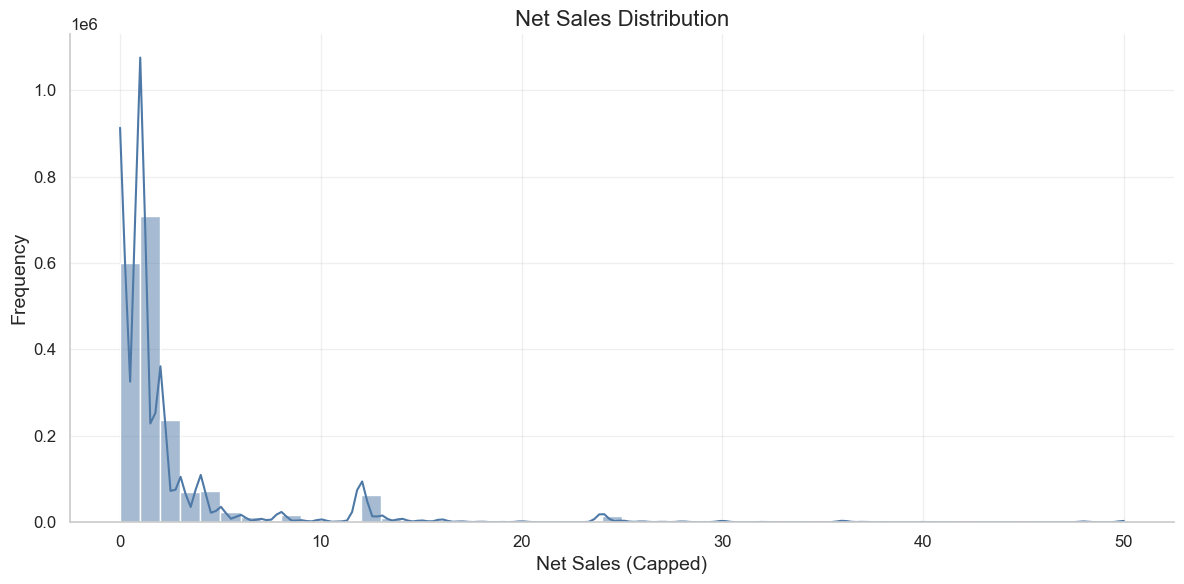

Returns Distribution
count    1.873617e+06
mean     1.096222e-02
std      3.135703e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.000000e+01
Name: Returns, dtype: float64


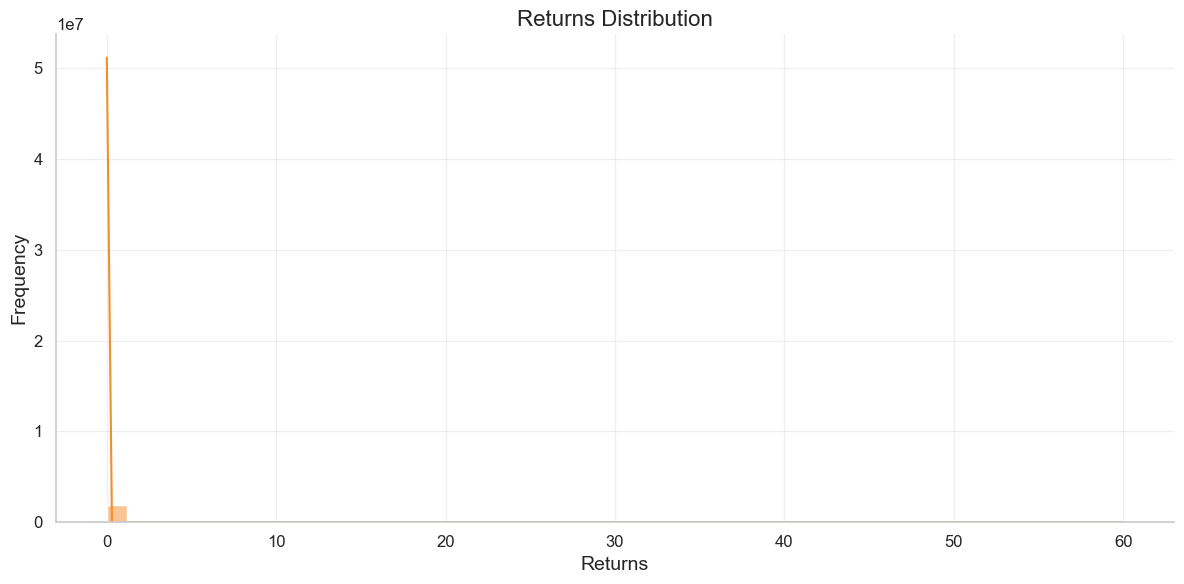

Category Counts
Product_Category
Fast      55.867555
Medium    35.858342
Slow       8.274103
Name: proportion, dtype: float64
Store_Category
Fast      47.963111
Medium    29.925380
Slow      22.111509
Name: proportion, dtype: float64


In [502]:
# Apply global style first
set_global_plot_style()

# Sales Distribution
print("Sales Distribution")
print(sales_df["Net_Sales_Capped"].describe())

plt.figure(figsize=(12, 6))
sns.histplot(
    data=sales_df, 
    x="Net_Sales_Capped", 
    bins=50, 
    kde=True, 
    color="#4E79A7"
)
plt.title("Net Sales Distribution", fontsize=16)
plt.xlabel("Net Sales (Capped)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Returns Distribution
print("Returns Distribution")
print(sales_df["Returns"].describe())

plt.figure(figsize=(12, 6))
sns.histplot(
    data=sales_df, 
    x="Returns", 
    bins=50, 
    kde=True, 
    color="#F28E2B"
)
plt.title("Returns Distribution", fontsize=16)
plt.xlabel("Returns", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Category counts
print("Category Counts")
print(sales_df["Product_Category"].value_counts(normalize=True)*100)
print(sales_df["Store_Category"].value_counts(normalize=True)*100)

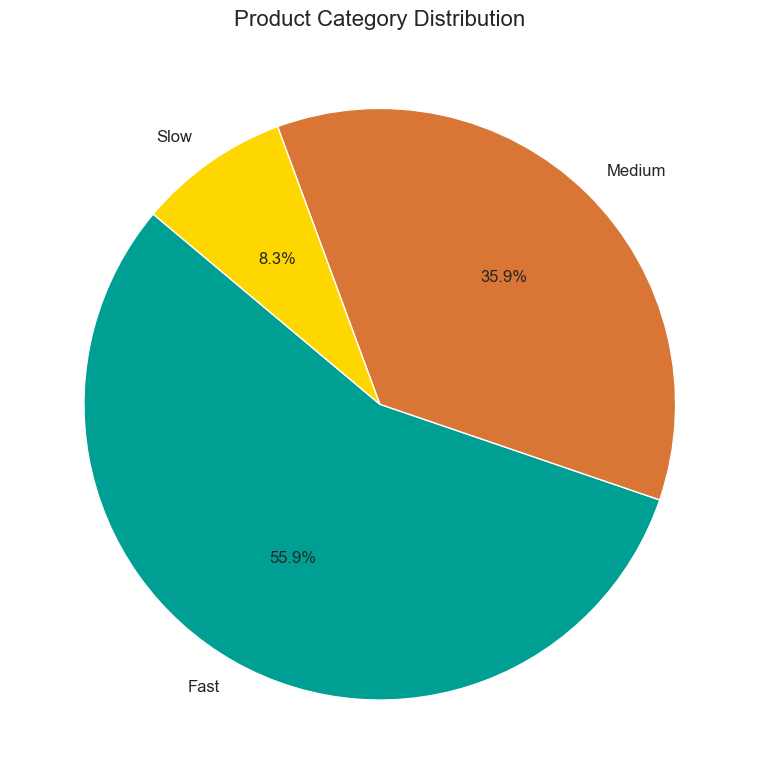

In [ ]:
plt.figure(figsize=(8, 8))
sales_df["Product_Category"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=140,
    colors=["#009F93", "#DA7635", "#FFD700"],  # Custom colors
    wedgeprops={"edgecolor": "white", "linewidth": 1},
    textprops={"fontsize": 12}
)
plt.title("Product Category Distribution", fontsize=16)
plt.ylabel("")
plt.tight_layout()
plt.savefig("product_category_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

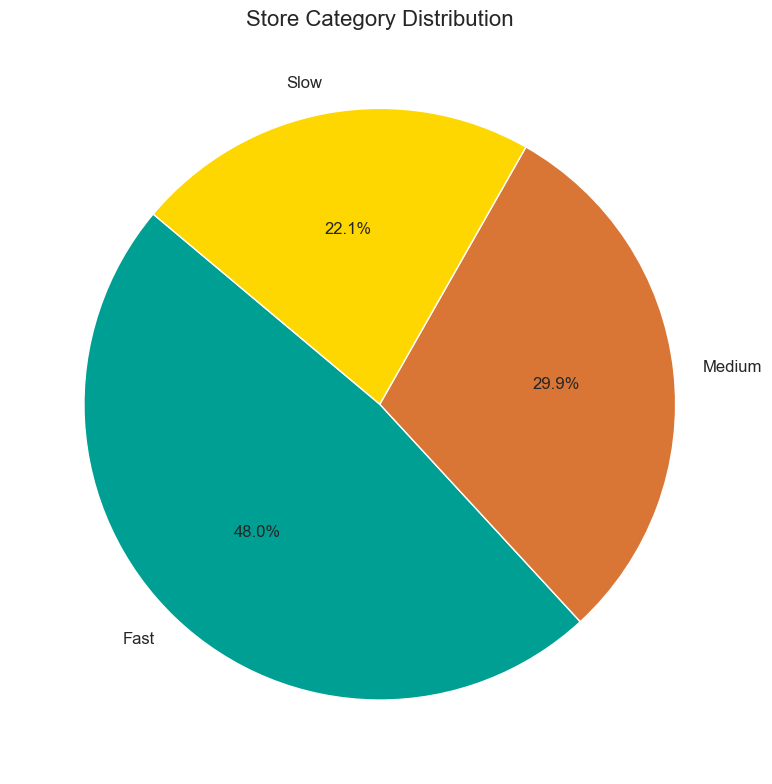

In [ ]:
plt.figure(figsize=(8, 8))
sales_df["Store_Category"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=140,
    colors=["#009F93", "#DA7635", "#FFD700"], 
    wedgeprops={"edgecolor": "white", "linewidth": 1},
    textprops={"fontsize": 12}
)
plt.title("Store Category Distribution", fontsize=16)
plt.ylabel("")  
plt.tight_layout()
plt.savefig("store_category_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


**Sales Distribution**

The sales data is highly right-skewed, with:

- A median of 1.0, indicating that over half of the transactions involve minimal sales.
- 75% of sales are 2 units or less, which is common in retail scenarios where small, frequent purchases dominate.
- The applied cap at 50 units successfully limits extreme sales outliers, stabilizing the dataset while preserving higher-value transactions.

This confirms that the dataset is heavily weighted toward small-scale transactions, and any promotional uplift analysis should account for the fact that typical sales are low. It also highlights the importance of ensuring that models and analysis are robust to skewed distributions, as most promotions are working from a very low baseline.

**Returns Distribution**

As expected, returns are very rare in the dataset:

- A median of 0, with 75% of records having no returns.
- An average of just 0.01, indicating that returns are infrequent.
- However, occasional large return events exist (with a maximum of 60 units), which could materially impact net sales during specific periods.

Although returns are infrequent, the presence of extreme return cases suggests that returns should still be monitored closely, especially during or after promotion periods, as they could diminish the financial impact of promotions.

**Category Counts**

Product and store clustering shows:

- Product Categories: The majority are Fast products (56%), with Medium (36%) and Slow (8%) making up the rest.
- Store Categories: Similarly, Fast stores (48%) dominate, followed by Medium (30%) and Slow (22%).

The dominance of Fast products and stores in the dataset may skew overall sales patterns toward these high-performing segments. This reinforces the need to analyze whether promotions and sales effects are truly driven by category differences or simply by volume concentration in the Fast groups.

### **Bivariate Analysis**

The bivariate analysis focuses on identifying how promotions, product categories, and store categories relate to net sales, as well as exploring any potential relationship between sales and returns.



In [505]:
# Net Sales vs. Promotion
print("\nNet Sales vs. Promotion")
print(sales_df.groupby("IsPromotion")["Net_Sales_Capped"].describe())

# Net Sales by Product Category
print("\nNet Sales by Product Category")
print(sales_df.groupby(("Product_Category"), observed=True,)["Net_Sales_Capped"].describe())

# Net Sales by Store Category
print("\nNet Sales by Store Category")
print(sales_df.groupby(("Store_Category"), observed=True,)["Net_Sales_Capped"].describe())

# Correlation check
print("\nCorrelation Check")
print(sales_df[["Net_Sales_Capped", "Returns"]].corr())


Net Sales vs. Promotion
                 count      mean       std  min  25%  50%  75%   max
IsPromotion                                                         
0            1562695.0  2.172070  4.555553  0.0  0.0  1.0  2.0  50.0
1             310922.0  2.575781  5.464574  0.0  0.0  1.0  2.0  50.0

Net Sales by Product Category
                      count      mean       std  min  25%  50%  75%   max
Product_Category                                                         
Slow               155025.0  0.459636  0.649186  0.0  0.0  0.0  1.0  17.0
Medium             671848.0  0.924194  1.291721  0.0  0.0  1.0  1.0  50.0
Fast              1046744.0  3.346546  5.996193  0.0  1.0  1.0  3.0  50.0

Net Sales by Store Category
                   count      mean       std  min  25%  50%  75%   max
Store_Category                                                        
Slow            414285.0  1.725114  3.667873  0.0  0.0  1.0  2.0  50.0
Medium          560687.0  2.028601  4.277173  0.0  0.0  

**Net Sales vs. Promotion**

The average net sales during promotion periods (2.58) are slightly higher than during non-promotion periods (2.17). However:

- The median net sales remain the same at 1.0 for both periods.
- The interquartile range is identical (25% = 0, 75% = 2), suggesting that for most transactions, promotions do not significantly increase the typical sale size.
- The increase in the mean reflects the impact of a few higher sales during promotions, but the effect is not widespread across all transactions.


While promotions contribute to a moderate increase in average sales, this uplift is driven by a limited number of larger transactions, and most sales remain small. This suggests that promotions may not equally benefit all products and stores and may primarily boost performance in specific segments.

**Net Sales by Product Category**

- Fast products have a much higher average net sales (3.39) compared to **Medium (0.92) and **Slow (0.46) products.
- The median for Fast products is 1.0, slightly better than Medium (1.0) and Slow (0.0), but still low overall.
- The higher standard deviation (6.03) for Fast products shows greater variability in sales, which is expected from high-performing products during promotions.

This suggests that Fast products are the key drivers of revenue and are likely the most responsive to promotions. Slow products contribute minimally to overall sales, indicating limited potential benefit from promotion investments.

**Net Sales by Store Category**

- Fast stores average 2.61 in net sales, followed by Medium stores (2.03) and Slow stores (1.72).
- Median sales are consistently low (1.0) across all store categories.
- Differences between store categories are present but less pronounced than between product categories.

While Fast stores perform better on average, the differences between store categories are narrower than those seen between product categories, which may suggest that products drive sales performance more strongly than store categories.

### **Multivariate Analysis**


This step examines how multiple variables interact — particularly the combined effect of promotions and product categories on both net sales and returns.

In [506]:
# Average sales during promotion by product category
print("\nNet Sales by Promotion and Product Category")
print(sales_df.groupby(["IsPromotion", "Product_Category"], observed=True)["Net_Sales_Capped"].mean().unstack())

# Returns during promotions by product category
print("\nReturns by Promotion and Product Category")
print(sales_df.groupby(["IsPromotion", "Product_Category"], observed=True)["Returns"].mean().unstack())

# Average uncapped sales during promotion by product category
print("\nUncapped Net Sales by Promotion and Product Category")
print(sales_df.groupby(["IsPromotion", "Product_Category"], observed=True)["Net_Sales"].mean().unstack())


Net Sales by Promotion and Product Category
Product_Category      Slow    Medium      Fast
IsPromotion                                   
0                 0.449665  0.911353  3.235394
1                 0.509620  0.988532  3.906540

Returns by Promotion and Product Category
Product_Category      Slow    Medium      Fast
IsPromotion                                   
0                 0.007304  0.011392  0.011001
1                 0.007874  0.011710  0.012085

Uncapped Net Sales by Promotion and Product Category
Product_Category      Slow    Medium      Fast
IsPromotion                                   
0                 0.449665  0.911353  3.260711
1                 0.509620  0.988532  3.979262


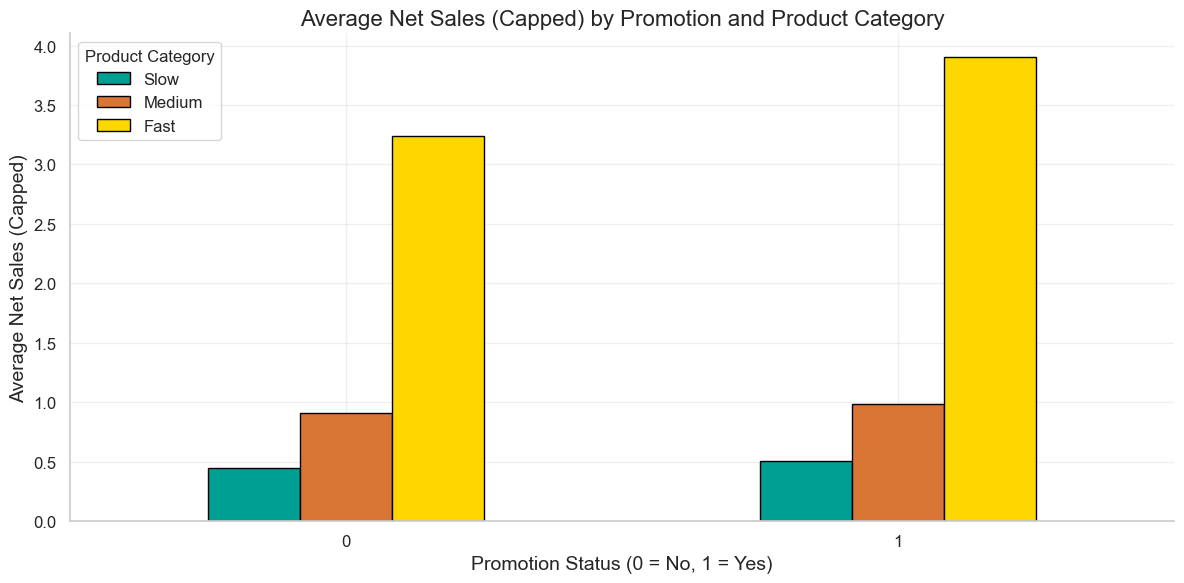

In [ ]:
avg_sales = sales_df.groupby(["IsPromotion", "Product_Category"], observed=True)["Net_Sales_Capped"].mean().unstack()

avg_sales.plot(
    kind="bar",
    figsize=(12, 6),
    color=["#009F93", "#DA7635", "#FFD700"],
    edgecolor="black"
)
plt.title("Average Net Sales (Capped) by Promotion and Product Category", fontsize=16)
plt.xlabel("Promotion Status (0 = No, 1 = Yes)", fontsize=14)
plt.ylabel("Average Net Sales (Capped)", fontsize=14)
plt.legend(title="Product Category", fontsize=12, title_fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("avg_net_sales_capped_by_promotion_and_category.png", dpi=300, bbox_inches="tight")
plt.show()


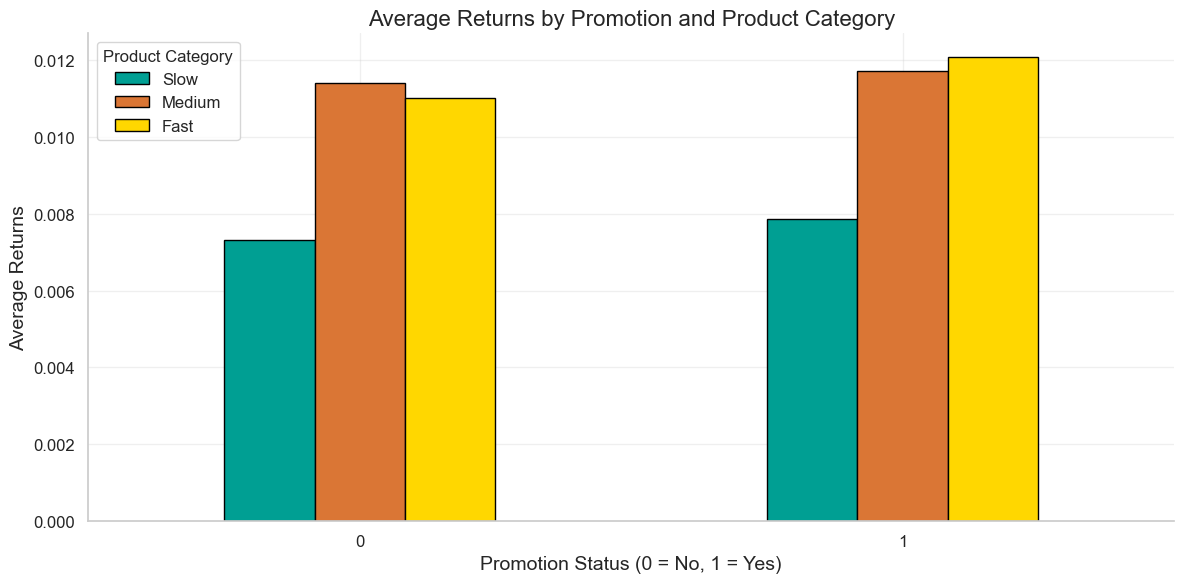

In [ ]:
avg_returns = sales_df.groupby(["IsPromotion", "Product_Category"], observed=True)["Returns"].mean().unstack()

avg_returns.plot(
    kind="bar",
    figsize=(12, 6),
    color=["#009F93", "#DA7635", "#FFD700"],
    edgecolor="black"
)
plt.title("Average Returns by Promotion and Product Category", fontsize=16)
plt.xlabel("Promotion Status (0 = No, 1 = Yes)", fontsize=14)
plt.ylabel("Average Returns", fontsize=14)
plt.legend(title="Product Category", fontsize=12, title_fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("avg_returns_by_promotion_and_category.png", dpi=300, bbox_inches="tight")
plt.show()

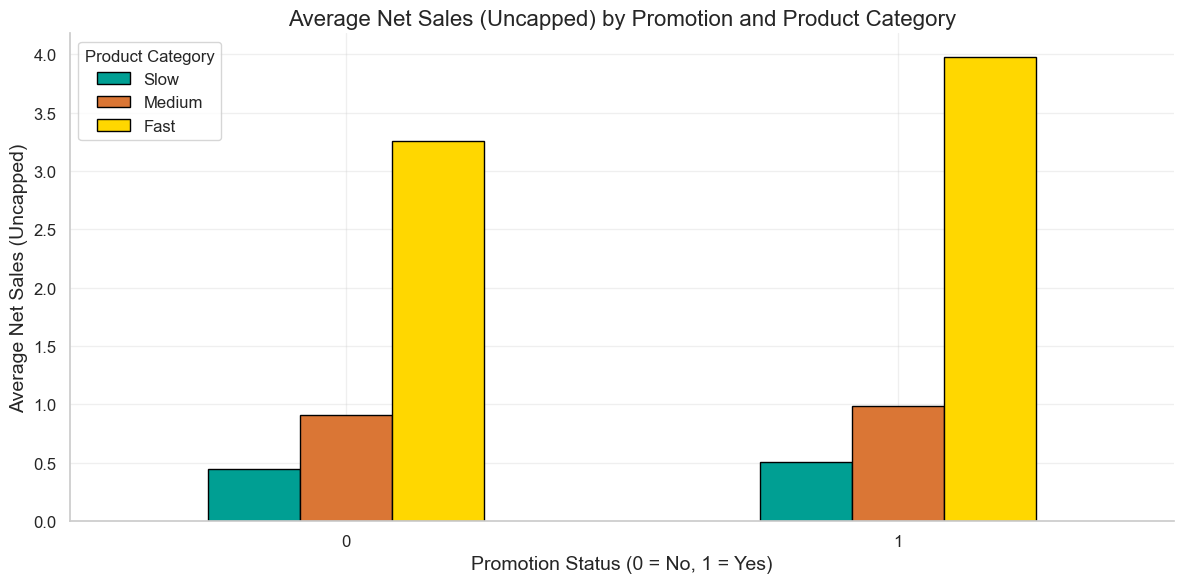

In [ ]:
avg_sales_uncapped = sales_df.groupby(["IsPromotion", "Product_Category"], observed=True)["Net_Sales"].mean().unstack()

avg_sales_uncapped.plot(
    kind="bar",
    figsize=(12, 6),
    color=["#009F93", "#DA7635", "#FFD700"],
    edgecolor="black"
)
plt.title("Average Net Sales (Uncapped) by Promotion and Product Category", fontsize=16)
plt.xlabel("Promotion Status (0 = No, 1 = Yes)", fontsize=14)
plt.ylabel("Average Net Sales (Uncapped)", fontsize=14)
plt.legend(title="Product Category", fontsize=12, title_fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("avg_net_sales_uncapped_by_promotion_and_category.png", dpi=300, bbox_inches="tight")
plt.show()


**Net Sales**
- Fast products see the biggest uplift during promotions (+0.67 increase in average net sales).
- Medium products show a small increase (+0.07).
- Slow products barely improve (+0.06), indicating limited promotional impact.

Promotions primarily benefit Fast products. Slow and Medium products show minimal gains, suggesting that promotional efforts are most effective when concentrated on Fast products. For Slow products, promotions may not justify the investment.

**Returns**
- Returns are slightly higher during promotions, but the differences are small.
- The increase is most noticeable for Fast products.
- Slow products maintain consistently low return levels.

While promotions slightly raise return rates, the increases are not significant enough to offset the sales benefits, particularly for Fast products. However, returns should still be monitored to ensure that heavily promoted products do not experience growing dissatisfaction.

**Comparison of Uncapped vs. Capped Net Sales**
To assess the impact of outlier capping on the analysis, we compared the mean net sales and returns between the capped and uncapped datasets.

- Uncapped data shows average of fast products during promotions is 3.98 in net sales.
- Capped data shows average of fast products during promotions is 3.91 in net sales.

Despite the extreme outliers removed through capping, the average sales for each product category, particularly the Fast products, remain similar in both capped and uncapped datasets. This indicates that while extreme high sales exist, they do not heavily distort the overall averages in this case, due to their rarity.

Likewise, the returns remain almost identical between the capped and uncapped datasets, confirming that the capping process primarily controlled rare, extreme sales values without impacting the core distribution of returns.

The close alignment between capped and uncapped results provides confidence that capping at 50 units successfully stabilizes the dataset without removing meaningful sales behavior. It ensures the model is protected from rare outlier events while keeping the general sales patterns intact.


### **Trend Analysis**

#### **Sales Trends**

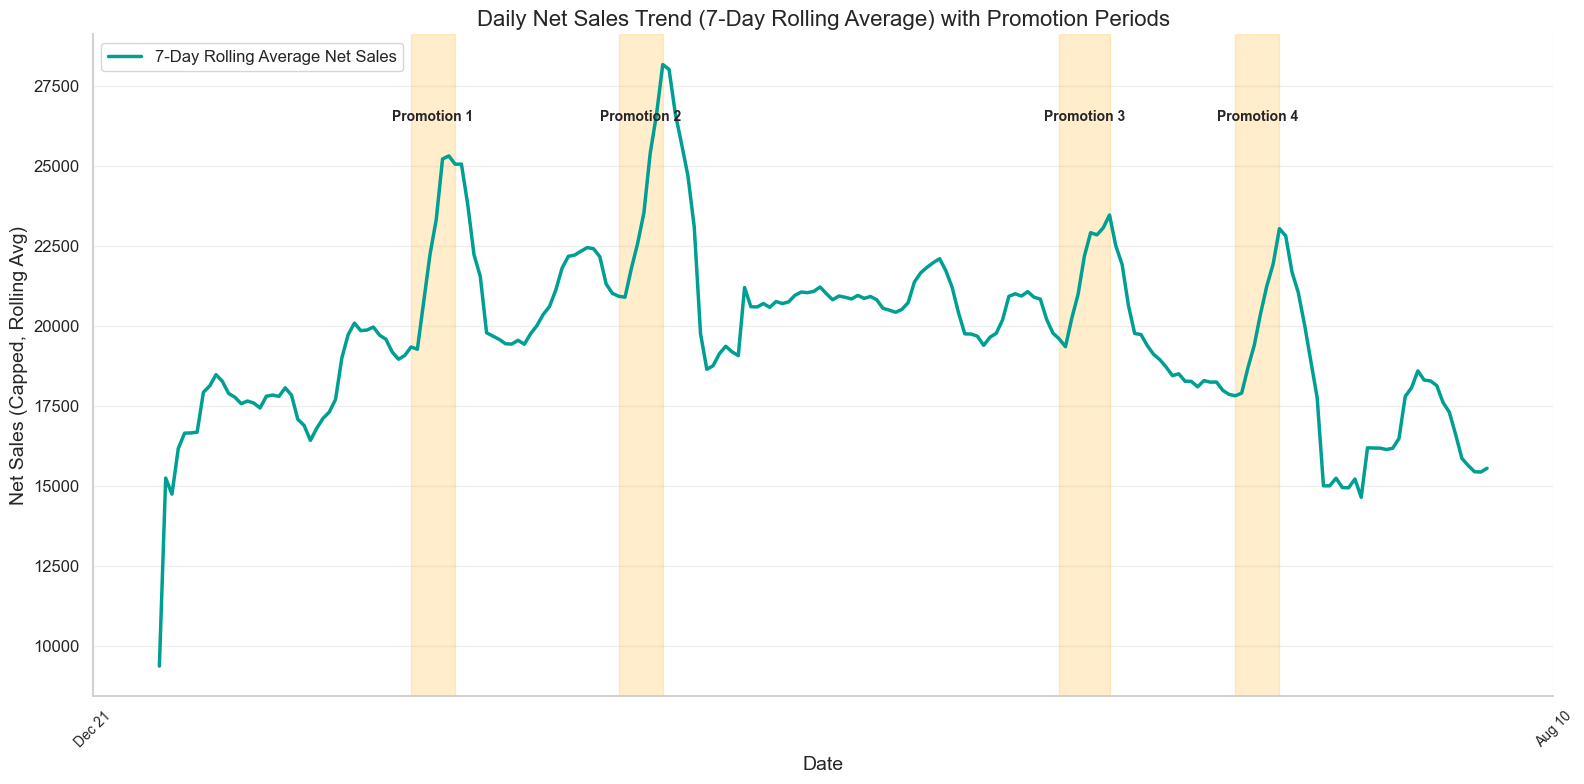

In [ ]:
import matplotlib.dates as mdates

# Aggregate total daily sales
daily_sales = sales_df.groupby("Date")["Net_Sales_Capped"].sum().reset_index()

# Apply 7-day rolling average
daily_sales["Rolling_Avg"] = daily_sales["Net_Sales_Capped"].rolling(window=7, min_periods=1).mean()

# Define promotion periods
promotion_periods = {
    "Promotion 1": ("2015-02-10", "2015-02-17"),
    "Promotion 2": ("2015-03-15", "2015-03-22"),
    "Promotion 3": ("2015-05-24", "2015-06-01"),
    "Promotion 4": ("2015-06-21", "2015-06-28")
}

# Convert dates for shading
for promo, (start, end) in promotion_periods.items():
    promotion_periods[promo] = (pd.to_datetime(start), pd.to_datetime(end))

plt.figure(figsize=(16, 8))

# Rolling average line
sns.lineplot(
    data=daily_sales,
    x="Date", y="Rolling_Avg",
    color="#009F93", 
    linewidth=2.5,
    label="7-Day Rolling Average Net Sales"
)

# Highlight promotion periods
for promo, (start_date, end_date) in promotion_periods.items():
    plt.axvspan(
        start_date, end_date, 
        color="orange",
        alpha=0.2
    )
    plt.text(
        x=start_date + (end_date - start_date) / 2,
        y=daily_sales["Rolling_Avg"].max() * 0.95,
        s=promo,
        ha="center", va="top", fontsize=10, fontweight="bold"
    )

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))

# Titles and labels
plt.title("Daily Net Sales Trend (7-Day Rolling Average) with Promotion Periods", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Sales (Capped, Rolling Avg)", fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("daily_net_sales_rolling_avg_with_promotions.png", dpi=300, bbox_inches="tight")
plt.show()


**Insights**
- Sales peaks align with promotion periods, showing a clear uplift during active campaigns.

- However, these peaks decline quickly, often returning to pre-promotion levels or lower within a few days of each promotion"s start, which may indicate a saturation effect where initial demand is rapidly fulfilled.
- Notably, Promotions 1 and 2 had stronger impacts compared to Promotions 3 and 4, suggesting that the effectiveness of promotions declined over time.
- Interestingly, Promotion 3 generated the least sales uplift, despite being the longest promotion period, which may suggest diminishing returns from extended campaigns or lower customer interest.
- Looking at the broader trend, there is a visible rise and fall pattern in overall weekly sales, pointing to potential seasonality or promotion fatigue as customers" responsiveness decreased over time.


#### **Returns**


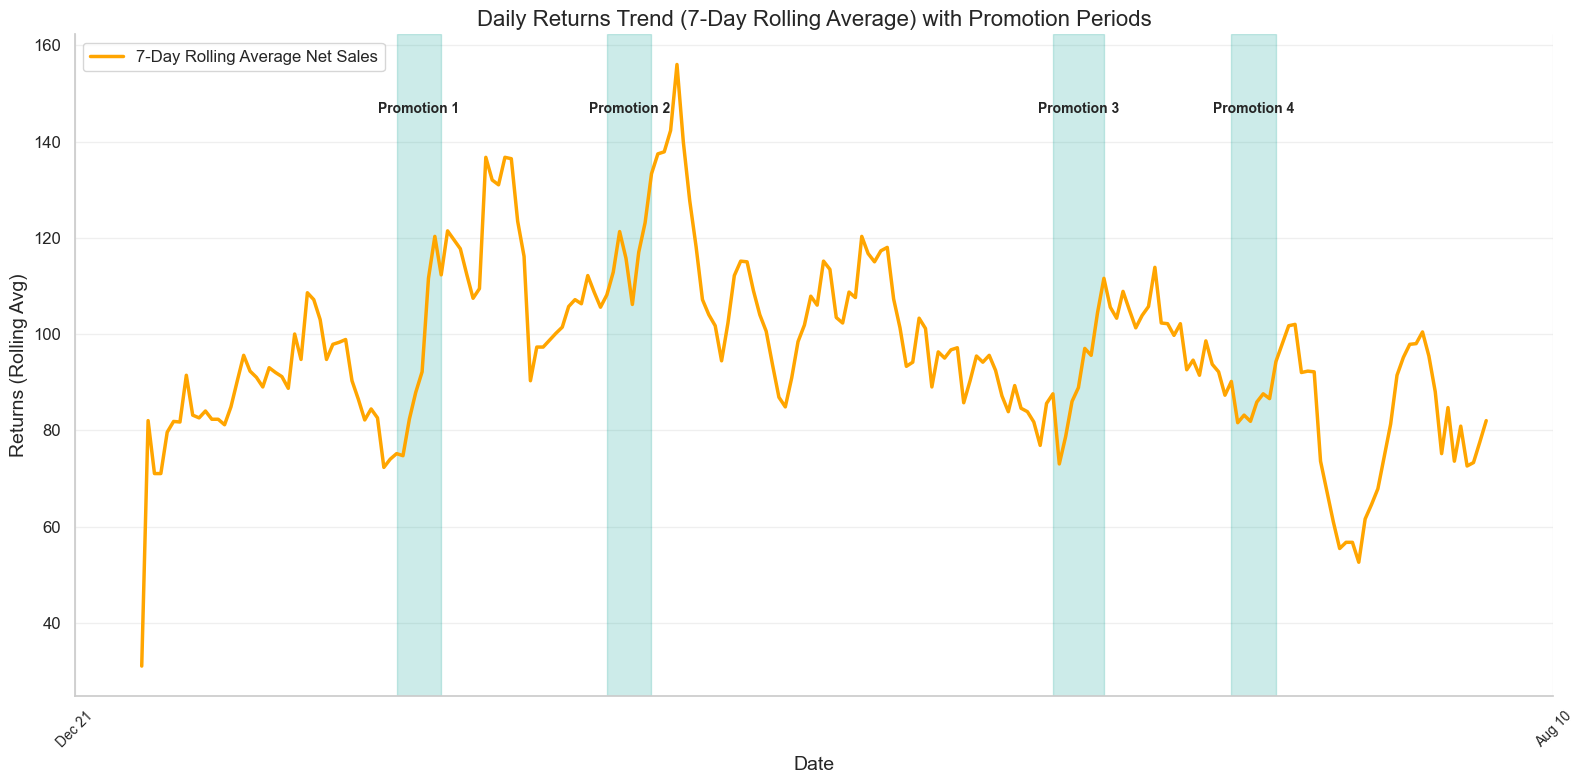

In [ ]:
import matplotlib.dates as mdates

# Aggregate total daily sales
daily_sales = sales_df.groupby("Date")["Returns"].sum().reset_index()

# Apply 7-day rolling average
daily_sales["Rolling_Avg"] = daily_sales["Returns"].rolling(window=7, min_periods=1).mean()

# Define promotion periods
promotion_periods = {
    "Promotion 1": ("2015-02-10", "2015-02-17"),
    "Promotion 2": ("2015-03-15", "2015-03-22"),
    "Promotion 3": ("2015-05-24", "2015-06-01"),
    "Promotion 4": ("2015-06-21", "2015-06-28")
}

# Convert dates for shading
for promo, (start, end) in promotion_periods.items():
    promotion_periods[promo] = (pd.to_datetime(start), pd.to_datetime(end))

plt.figure(figsize=(16, 8))

# Rolling average line
sns.lineplot(
    data=daily_sales,
    x="Date", y="Rolling_Avg",
    color="orange",  # Teal from the global palette
    linewidth=2.5,
    label="7-Day Rolling Average Net Sales"
)

# Highlight promotion periods
for promo, (start_date, end_date) in promotion_periods.items():
    plt.axvspan(
        start_date, end_date, 
        color="#009F93",
        alpha=0.2
    )
    plt.text(
        x=start_date + (end_date - start_date) / 2,
        y=daily_sales["Rolling_Avg"].max() * 0.95,
        s=promo,
        ha="center", va="top", fontsize=10, fontweight="bold"
    )

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))

# Titles and labels
plt.title("Daily Returns Trend (7-Day Rolling Average) with Promotion Periods", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Returns (Rolling Avg)", fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("daily_returns_rolling_avg_with_promotions.png", dpi=300, bbox_inches="tight")
plt.show()


**Insights**

- Slight increases in returns were observed during promotion periods, though these peaks are significantly less pronounced than sales spikes. This suggests that while promotions drive higher purchase volumes, only a small proportion of those sales are returned immediately.

- A more noticeable rise in returns typically occurs within a week after promotions end. This delay likely reflects two primary factors:
    - Overbuying during promotions, as customers take advantage of discounts to purchase in larger quantities than usual, sometimes beyond actual needs.
    - Regret-driven returns, where customers reconsider their purchases after the excitement of the promotion fades, leading to post-promotion product returns.

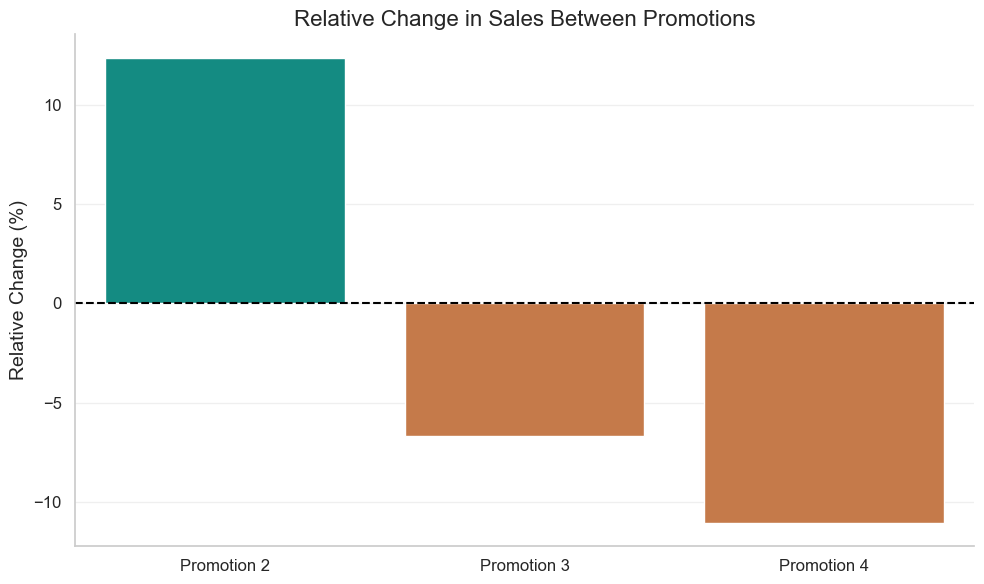

In [ ]:
# Define promotion periods 
promotion_periods = {
    "Promotion 1": ("2015-02-10", "2015-02-17"),
    "Promotion 2": ("2015-03-15", "2015-03-22"),
    "Promotion 3": ("2015-05-24", "2015-06-01"),
    "Promotion 4": ("2015-06-21", "2015-06-28")
}

# Calculate total sales during each promotion period
promo_sales = {}
for promo, (start_date, end_date) in promotion_periods.items():
    mask = (sales_df["Date"] >= start_date) & (sales_df["Date"] <= end_date)
    promo_sales[promo] = sales_df.loc[mask, "Net_Sales_Capped"].sum()

# Calculate relative changes in sales between promotions
promo_changes = []
promos = list(promo_sales.keys())
for i in range(1, len(promos)):
    prev_sales = promo_sales[promos[i - 1]]
    current_sales = promo_sales[promos[i]]
    change = ((current_sales - prev_sales) / prev_sales) * 100
    promo_changes.append({
        "Promotion": promos[i],
        "Relative Change (%)": change
    })

# Convert to DataFrame for plotting
promo_change_df = pd.DataFrame(promo_changes)

# Plot the relative changes in sales between promotions
plt.figure(figsize=(10, 6))
colors = ["#009F93" if x >= 0 else "#DA7635" for x in promo_change_df["Relative Change (%)"]]
sns.barplot(
    data=promo_change_df,
    x="Promotion",
    y="Relative Change (%)",
    hue="Promotion",
    legend=False,
    palette=colors
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Relative Change in Sales Between Promotions", fontsize=16)
plt.xlabel("")
plt.ylabel("Relative Change (%)", fontsize=14)
plt.tight_layout()
plt.savefig("relative_change_between_promotions.png", dpi=300, bbox_inches="tight")
plt.show()

In [513]:
print(promo_change_df)

     Promotion  Relative Change (%)
0  Promotion 2            12.396711
1  Promotion 3            -6.705949
2  Promotion 4           -11.054242


with this graph, we can simply observe the diminishing impact of promotions. Where first promotion increases sales significantly, this effect almost vanishes in promotion 4.

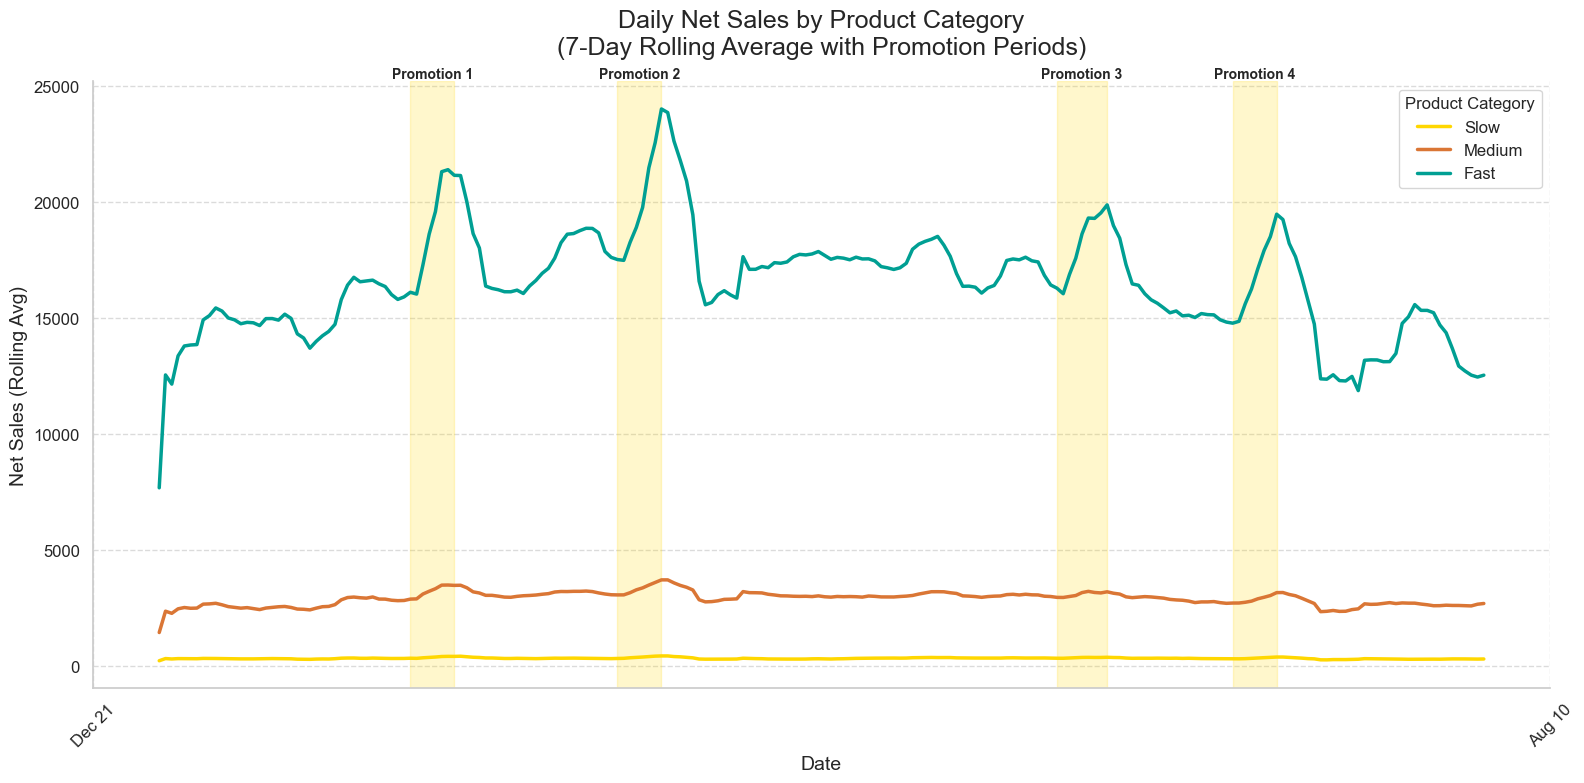

In [571]:

# Aggregate daily sales by Product Category
daily_product_sales = sales_df.groupby(["Date", "Product_Category"], observed=True)["Net_Sales_Capped"].sum().reset_index()

# Apply 7-day rolling average for smoothing
daily_product_sales["Rolling_Avg"] = daily_product_sales.groupby(("Product_Category"), observed=True)["Net_Sales_Capped"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Convert promotion dates to datetime for plotting
for promo, (start, end) in promotion_periods.items():
    promotion_periods[promo] = (pd.to_datetime(start), pd.to_datetime(end))

# Colors assigned to Product Categories
category_colors = {
    "Fast": "#009F93",
    "Medium": "#DA7635",
    "Slow": "#FFD700"
}

# Plot
plt.figure(figsize=(16, 8))

# Lineplot for each Product Category with consistent colors
sns.lineplot(
    data=daily_product_sales,
    x="Date",
    y="Rolling_Avg",
    hue="Product_Category",
    palette=category_colors,
    linewidth=2.5
)

# Highlight promotion periods
for promo, (start_date, end_date) in promotion_periods.items():
    plt.axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="#FFD700", alpha=0.2)
    plt.text(
        x=start_date + (end_date - start_date) / 2,
        y=daily_product_sales["Rolling_Avg"].max() * 1.05,
        s=promo,
        ha="center", va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# Formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))

plt.title("Daily Net Sales by Product Category\n(7-Day Rolling Average with Promotion Periods)", fontsize=18, pad=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Sales (Rolling Avg)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Product Category", fontsize=12, title_fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Save high-resolution figure
plt.savefig("daily_net_sales_by_product_category.png", dpi=300)
plt.show()

#### **Reaction of Product Groups and Stores to Promotions**

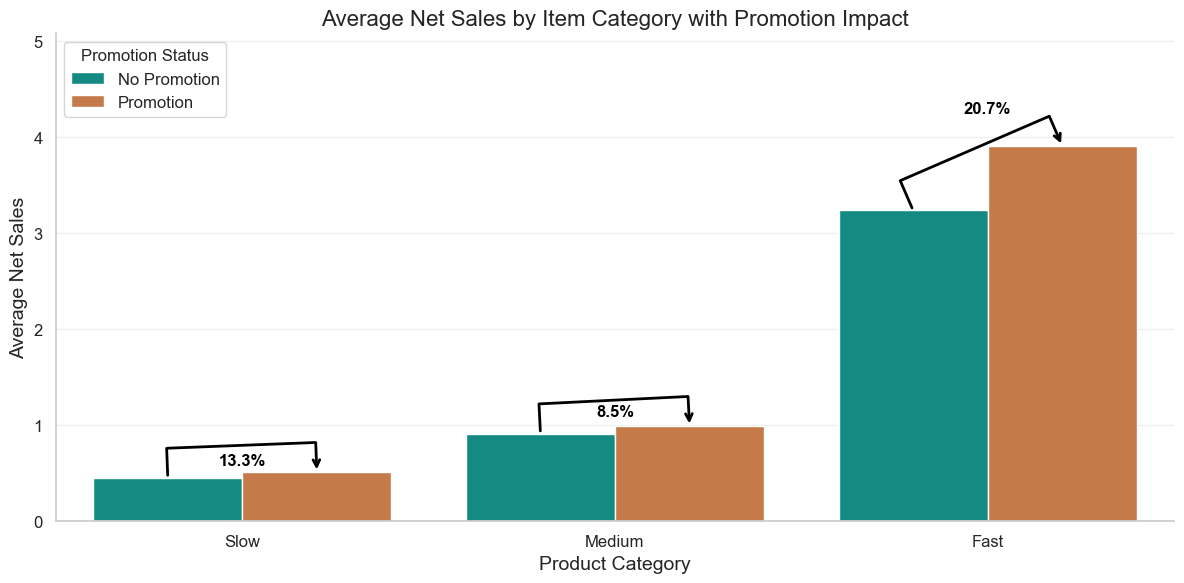

In [ ]:
# Map promotion status
sales_viz= sales_df.copy()
sales_viz["Promotion_Status"] = sales_viz["IsPromotion"].map({0: "No Promotion", 1: "Promotion"})

# Calculate average sales during and outside promotions per product category
avg_sales_product = sales_viz.groupby(["Promotion_Status", "Product_Category"], observed=True)["Net_Sales_Capped"].mean().reset_index()

# Pivot the data to compute percentage difference
pivot_sales_product = avg_sales_product.pivot(index="Product_Category", columns="Promotion_Status", values="Net_Sales_Capped").reset_index()
pivot_sales_product["Percentage Change"] = (
    (pivot_sales_product["Promotion"] - pivot_sales_product["No Promotion"]) /
    pivot_sales_product["No Promotion"]
) * 100


plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=avg_sales_product,
    x="Product_Category",
    y="Net_Sales_Capped",
    hue="Promotion_Status",
    palette=["#009F93", "#DA7635"],
)
plt.title("Average Net Sales by Item Category with Promotion Impact", fontsize=16)
plt.xlabel("Product Category", fontsize=14)
plt.ylabel("Average Net Sales", fontsize=14)
plt.legend(title="Promotion Status", fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, pivot_sales_product[["No Promotion", "Promotion"]].values.max() * 1.3)


# Curved arrows with percentage change
for idx, row in pivot_sales_product.iterrows():
    no_promo = row["No Promotion"]
    promo = row["Promotion"]
    change = row["Percentage Change"]

    # X positions of bars
    x_no_promo = idx - 0.2
    x_promo = idx + 0.2

    # Draw curved arrow between bars
    plt.annotate(
        "",
        xy=(x_promo, promo),
        xytext=(x_no_promo, no_promo),
        arrowprops=dict(
            arrowstyle="->",
            color="black",
            linewidth=2,
            connectionstyle="bar,fraction=-0.2"  # Controls the curve (positive for upward arc)
        )
    )

    # Dynamically adjust text position to avoid title overlap
    max_height = max(no_promo, promo)
    offset = max_height * 0.08  # 8% of the tallest bar
    mid_x = (x_no_promo + x_promo) / 2
    mid_y = max_height + offset
    plt.text(
        mid_x,
        mid_y,
        f"{change:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
        color="black"
    )
plt.tight_layout()
plt.savefig("avg_net_sales_by_product_category_with_pct_change.png", dpi=300, bbox_inches="tight")
plt.show()


-  All item categories (Slow, Medium, Fast) show an increase in average sales during promotions. This demonstrates that promotions generally stimulate sales across the product range.
- The percentage change reveals significant differences in how promotions affect each category:
    - Slow items experience a 13.33% increase.
 - Medium items show a relatively modest 8.47% increase.
    - Fast items exhibit a substantial 20.74% increase.
    
    This indicates that promotions are most effective for fast selling items, and least effective for medium selling items.

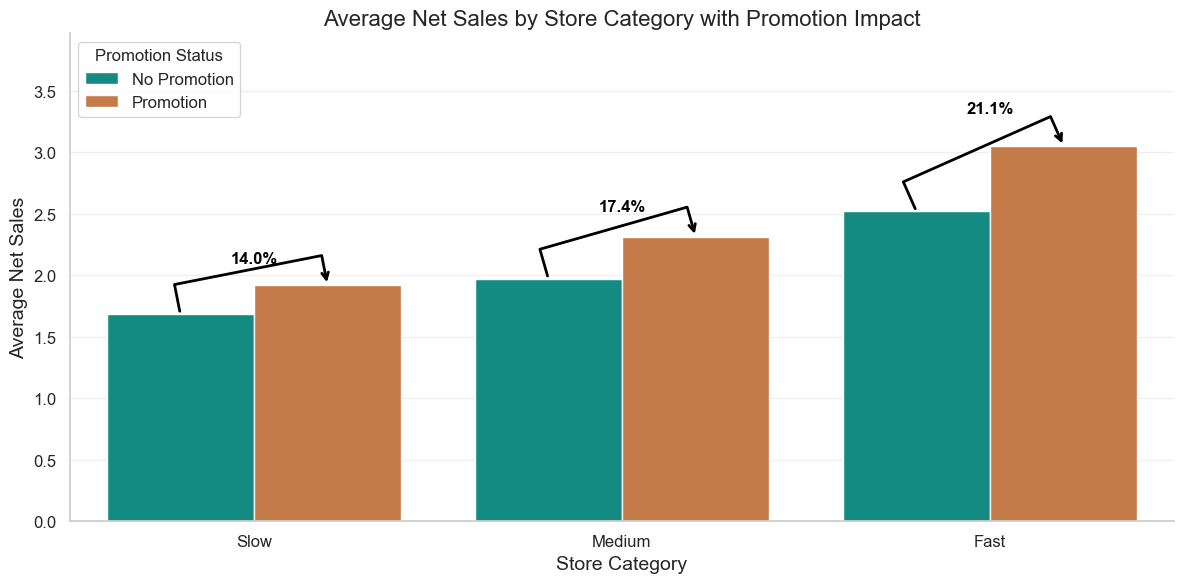

In [ ]:

# Calculate average sales during and outside promotions per store category
avg_sales_store = sales_viz.groupby(["Promotion_Status", "Store_Category"], observed=True)["Net_Sales_Capped"].mean().reset_index()

# Pivot the data to compute percentage difference
pivot_sales_store = avg_sales_store.pivot(index="Store_Category", columns="Promotion_Status", values="Net_Sales_Capped").reset_index()
pivot_sales_store["Percentage Change"] = (
    (pivot_sales_store["Promotion"] - pivot_sales_store["No Promotion"]) /
    pivot_sales_store["No Promotion"]
) * 100


plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=avg_sales_store,
    x="Store_Category",
    y="Net_Sales_Capped",
    hue="Promotion_Status",
    palette=["#009F93", "#DA7635"],
)
plt.title("Average Net Sales by Store Category with Promotion Impact", fontsize=16)
plt.xlabel("Store Category", fontsize=14)
plt.ylabel("Average Net Sales", fontsize=14)
plt.legend(title="Promotion Status", fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, pivot_sales_store[["No Promotion", "Promotion"]].values.max() * 1.3) # Set the y-axis limit to 30% above the tallest bar


# Curved arrows with percentage change
for idx, row in pivot_sales_store.iterrows():
    no_promo = row["No Promotion"]
    promo = row["Promotion"]
    change = row["Percentage Change"]

    # X positions of bars
    x_no_promo = idx - 0.2
    x_promo = idx + 0.2

    # Draw curved arrow between bars
    plt.annotate(
        "",
        xy=(x_promo, promo),
        xytext=(x_no_promo, no_promo),
        arrowprops=dict(
            arrowstyle="->",
            color="black",
            linewidth=2,
            connectionstyle="bar,fraction=-0.2"  # Controls the curve (positive for upward arc)
        )
    )

    # Dynamically adjust text position to avoid title overlap
    max_height = max(no_promo, promo)
    offset = max_height * 0.08  # 8% of the tallest bar
    mid_x = (x_no_promo + x_promo) / 2
    mid_y = max_height + offset
    plt.text(
        mid_x,
        mid_y,
        f"{change:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
        color="black"
    )
plt.tight_layout()
plt.savefig("avg_net_sales_by_store_category_with_pct_change.png", dpi=300, bbox_inches="tight")
plt.show()


- All store categories (Slow, Medium, Fast) experience an increase in average sales during promotional periods. This confirms that promotions are effective in boosting sales across all store performance levels.
- The percentage change in sales is more significant in higher-performing stores.
    - Slow stores show a 13.98% increase.
    - Medium stores show a 17.35% increase.
    - Fast stores show a 21.06% increase.
- This suggests that promotions have a greater impact on stores that already have higher baseline sales.

## **Statistical and Comperative Analysis**

In this section, we followed a question-oriented format to provide insights and make data driven recommendations. In order to provide actionable insights, we conducted a series of statistical and comperative analysis.

### **Which items experienced the biggest sale increase during promotions?**

To identify which items and production group combinations experienced the biggest sales increase during promotions, we calculated the percentage sales change for each item and product group between promotion and non-promotion periods. 

In [517]:
# Calculate average sales per product group during and outside promotions
promo_effect = sales_df.groupby(["Product_Category", "IsPromotion"], observed=True)["Net_Sales_Capped"].mean().unstack()

# Calculate % increase during promotions
promo_effect["% Increase"] = ((promo_effect[1] - promo_effect[0]) / promo_effect[0]) * 100

# Sort by highest percentage increase
promo_effect = promo_effect.sort_values("% Increase", ascending=False)

print(promo_effect)


IsPromotion              0         1  % Increase
Product_Category                                
Fast              3.235394  3.906540   20.743865
Slow              0.449665  0.509620   13.333136
Medium            0.911353  0.988532    8.468589


For items, all categories saw increase on average. Top performing items are Fast items (21% increase) followed by Slow items (13% increase) and lastly Medium items (8% increase). Even if Medium items has higher overall sales, Slow items has higher relative sales inclrease. Meaning that Fast and Slow items react better to promotions.

In [518]:
# Make sure the combo exists in the sales_df
sales_df["ProductGroup_Combo"] = sales_df["ProductGroup1"].astype(str) + "_" + sales_df["ProductGroup2"].astype(str)

# Group by ProductGroup_Combo and Promotion status
promo_effect = sales_df.groupby(["ProductGroup_Combo", "IsPromotion"])["Net_Sales_Capped"].mean().unstack()

# Calculate percentage increase
promo_effect["% Increase"] = ((promo_effect[1] - promo_effect[0]) / promo_effect[0]) * 100

# Sort to find the biggest increases
promo_effect = promo_effect.sort_values("% Increase", ascending=False)

# Display the top 10
print(promo_effect.head(10))

IsPromotion                0         1  % Increase
ProductGroup_Combo                                
A_20                0.257143  0.691176  168.790850
A_5                 3.190564  4.160745   30.407796
D_21                0.385029  0.495413   28.668956
E_28                0.788268  0.960552   21.855926
J_27                0.821724  0.997412   21.380371
G_25                1.580980  1.894651   19.840240
J_8                 1.468365  1.747826   19.032145
E_13                0.467005  0.548780   17.510604
A_26                1.735450  2.000077   15.248322
E_14                2.144746  2.468290   15.085378


On the top-performing groups part, such as A-20, showed sales increases exceeding 169%, indicating strong positive reaction. A-5 and D-21 product group combinations followed it by 30% and 29% increases respectively, indicating positive reactions to promotions and priority candidates for future campaigns.

#### **Recommendations for Promotions**

1. **Focus on Fast items to drive high absolute sales gains.** While Fast items had a +20.7% relative increase, they contribute much larger total sales volumes than Medium or Slow items. For this, fast products can be prioritized in major promotion periods to maximize overall revenue. In addition, Fast items can be act as lead products in campaigns to attract customers.

2. **Explore growth opportunities with Slow and Medium items.** Slow items (+13.3%) and Medium items (+8.5%) also benefit from promotions, though to a lesser degree. Hence, there may be untapped potential in these groups if supported with targeted promotions. As actions, promotions can be used on Slow/Medium items to clear stock or test their growth potential and Slow and Medium items can paired with Fast items in bundles or cross-promotions to boost their visibility and sales.

3. **Prioritize promotions on high-response product groups.** Product groups like A_20 (+169%), A_5 (+30%), and D_21 (+29%) showed the highest percentage sales increases during promotions. These product groups can be primary targets in future promotion campaigns and a larger share of marketing budgets and promotion resources may be allocated to these high-impact groups. Though these promotions should be done cautiously to prevent diminishing returns due to repeated promotions.



### **Which items have cannibalized items in the same Productgroup1-ProductGroup2 combination?**

To uncover cannibalization, it is required to check if within the same product group, some items" sales decrease during promotions, especially if other items in the same group are being promoted. If an item"s sales decrease during promotions (while others in the same combo increase), it is a cannibalization candidate. However, it should be kept in mind that negative change during the promotions might not always directly indicates cannibalization, as other factors (e.g., market conditions, external factors) could also lead to a decrease in sales. Though, it is a good starting point to identify potential identify cannibalization.

To thoroughly investigate cannibalization effects during promotions, especially during Promotion 1 to Promotion 4, we applied two complementary analytical methods. These methods were designed to capture both product-level impacts and group-level dynamics within the same product families.

#### **Product-Level Cannibalization**

Firstly, we focuse on individual products within their respective ProductGroup_Combo (a combination of ProductGroup1 and ProductGroup2). 
We calculated average sales for each product in the 4 weeks before promotions (as a baseline) and during the promotion periods. For each product, we measured the percentage change in sales between the pre-promotion and promotion periods. This allows us to directly identify products whose sales decreased during promotions, making them potential victims of cannibalization. By isolating these underperforming products, we gain a clear view of which items suffer during promotions, regardless of the behavior of other products in the same group.

This method provides granular insight, allowing us to detect specific items whose sales consistently decline during promotional periods, helping the business decide which products need protection or alternative strategies during future promotions.


In [ ]:
# Define Promotion 1 to Promotion 4 periods
promotion_periods = [
    ("2015-02-10", "2015-02-17"),
    ("2015-03-15", "2015-03-22"),
    ("2015-05-24", "2015-06-01"),
    ("2015-06-21", "2015-06-28"),
]

# Add product group combo
sales_df["ProductGroup_Combo"] = sales_df["ProductGroup1"].astype(str) + "_" + sales_df["ProductGroup2"].astype(str)

# Get promotion period data
promo_periods = []
for start, end in promotion_periods:
    promo_periods.append(
        sales_df[(sales_df["Date"] >= pd.to_datetime(start)) & (sales_df["Date"] <= pd.to_datetime(end))]
    )
promo_data = pd.concat(promo_periods)

# Get 4-week pre-promotion period data for baseline comparison
pre_promo_periods = []
for start, _ in promotion_periods:
    start_date = pd.to_datetime(start)
    pre_promo_periods.append(
        sales_df[(sales_df["Date"] < start_date) & (sales_df["Date"] >= start_date - pd.Timedelta(weeks=4))]
    )
pre_promo_data = pd.concat(pre_promo_periods)

Now, we can detect individual products that lost sales during promotions comparing to the pre-promotion average sales.

In [ ]:
# Calculate average sales per product before and during promotions
pre_promo_avg = pre_promo_data.groupby(["ProductGroup_Combo", "ProductCode"])["Net_Sales_Capped"].mean().reset_index()
pre_promo_avg.rename(columns={"Net_Sales_Capped": "Pre_Promo_Avg_Sales"}, inplace=True)

promo_avg = promo_data.groupby(["ProductGroup_Combo", "ProductCode"])["Net_Sales_Capped"].mean().reset_index()
promo_avg.rename(columns={"Net_Sales_Capped": "Promo_Avg_Sales"}, inplace=True)

# Merge averages to compare
product_comparison = pd.merge(pre_promo_avg, promo_avg, on=["ProductGroup_Combo", "ProductCode"])

# Calculate percentage change
product_comparison["% Change"] = ((product_comparison["Promo_Avg_Sales"] - product_comparison["Pre_Promo_Avg_Sales"]) / product_comparison["Pre_Promo_Avg_Sales"]) * 100

# Find products with sales decrease (possible cannibalization)
cannibalized_products = product_comparison[product_comparison["% Change"] < 0].sort_values("% Change")

# Add product categories for interpretation
cannibalized_products = pd.merge(cannibalized_products, sales_df[["ProductCode", "Product_Category"]].drop_duplicates(), on="ProductCode", how="left")

# Display top cannibalized products
print(cannibalized_products.head(20))

   ProductGroup_Combo  ProductCode  Pre_Promo_Avg_Sales  Promo_Avg_Sales  \
0                 F_2          164             0.255814         0.000000   
1                 J_8          125             0.461538         0.250000   
2                 A_5          110             3.388855         2.054449   
3                B_18          148             3.337700         2.215606   
4                H_15           55             0.500000         0.333333   
5                 F_2          298             0.512195         0.342105   
6                 F_7          113             0.552878         0.396501   
7                D_29          132             0.681818         0.500000   
8                 J_8          117             0.404110         0.302632   
9                G_11           82             0.435701         0.342342   
10                A_5          246             3.772531         3.040509   
11               E_14           12             0.307692         0.250000   
12          

At the product level, we analyzed the change in average sales for individual products during the four major promotion periods, comparing them to their baseline sales from the previous four weeks.

The results revealed a consistent pattern of decline for several products, indicating they might have been negatively impacted during promotional periods. For instance:

- Product 164 (Combo F_2) experienced a 100% drop in sales during promotions, with sales falling from an average of 0.26 units to 0.00.
- Product 110 (Combo A_5) saw its sales decrease by 39.4%, from 3.39 units to 2.05 units.
- Product 148 (Combo B_18) dropped by 33.6%, signaling a substantial loss.

The top cannibalized products showed declines ranging from -10% to -100%, affecting products across categories:
- Slow-moving items (e.g., Product 164, 125, 55) were among the most vulnerable.
- Even some Fast products (like Product 110 and 148) experienced notable declines.

This suggests that cannibalization is not limited to weaker-performing products but can impact key revenue drivers as well.

#### **ProductGroup Combination Level Cannibalization**

To direclty answer case study"s question, in the second analysis, we investigate ProductGroup_Combos that exhibit mixed behavior during promotions. Some products in the combo can be increased in sales, others in the same combo can be decreased. By identifying these combinations, we can highlight groups where internal competition arises during promotions.

Once we detect these mixed-behavior combos, we zoom in on the most negatively impacted products within these cannibalized groups, further prioritizing which products deserve attention.

In [ ]:
# Identify combos with mixed sales behavior during promotions
mixed_behavior_combos = []
for combo, group in product_comparison.groupby("ProductGroup_Combo"):
    if (group["% Change"] > 0).any() and (group["% Change"] < 0).any():
        mixed_behavior_combos.append(combo)

# Extract products in combos with mixed behavior
combo_cannibalization_cases = product_comparison[product_comparison["ProductGroup_Combo"].isin(mixed_behavior_combos)]

# Add product categories for interpretation
combo_cannibalization_cases = pd.merge(combo_cannibalization_cases, sales_df[["ProductCode", "Product_Category"]].drop_duplicates(), on="ProductCode", how="left")

# Show top negatively impacted products in mixed-behavior combos
print(combo_cannibalization_cases.sort_values("% Change").head(20))

    ProductGroup_Combo  ProductCode  Pre_Promo_Avg_Sales  Promo_Avg_Sales  \
131                F_2          164             0.255814         0.000000   
256                J_8          125             0.461538         0.250000   
8                  A_5          110             3.388855         2.054449   
200               H_15           55             0.500000         0.333333   
132                F_2          298             0.512195         0.342105   
98                D_29          132             0.681818         0.500000   
255                J_8          117             0.404110         0.302632   
152               G_11           82             0.435701         0.342342   
49                 A_5          246             3.772531         3.040509   
109               E_14           12             0.307692         0.250000   
7                  A_5          109             2.593822         2.163636   
112               E_14           34             1.428571         1.200000   

To understand whether cannibalization was occurring within groups (ProductGroup_Combos), we analyzed whether some products within the same group increased their sales during promotions while others decreased—a clear signature of internal competition.

The results flagged multiple combos with this mixed behavior, with several combos showing strong evidence of cannibalization:

- Combo F_2 had products dropping by 100%, 33%, and 14%.
- Combo A_5 showed repeated product-level declines of around 39%, 19%, and 11%.
- Combo J_8 also demonstrated notable declines for multiple products, including -45.8% and -25.1%.

The fact that these combos contain both increasing and decreasing products during promotions confirms the presence of internal cannibalization.



#### **Recommendations for Cannibalization**
1. **Avoid simultaneous promotions within high-risk combos like F_2, A_5, J_8, and B_18.** Our analysis reveals strong internal competition within these product group combinations. For example:
    - Product 164 in F_2 experienced a 100% sales drop during promotions.
    - Products in A_5 consistently showed sales declines around 11–39%.
    - Products in J_8 and B_18 also suffered losses exceeding 30%.

    This indicates that promoting multiple items within the same combo during the same period causes direct cannibalization. Implementing staggered or alternating promotions across products in these combos to can reduce overlap and protect overall group sales.

2. **Focus promotions on the best-performing products within each group.** To maximize promotion effectiveness while minimizing cannibalization:
    - Identify the top-selling, high-margin items within each product group combo.
    - Prioritize these leaders (e.g., highest historical sales performers in combos like A_5 and B_18) for focused promotions.
    - Reduce or eliminate concurrent promotions for weaker products within the same group.

    This helps concentrate demand on the most profitable items and prevents internal competition from eroding group sales.

3. **Design targeted, non-overlapping promotion calendars to prevent fatigue and sales erosion.** Back-to-back or overlapping promotions in the same group result in diminishing returns and cannibalization.
    - Build a rotation strategy where high-risk combos like F_2, J_8, and B_18 have spaced-out promotions.
    - Ensure sufficient "cool-down" periods between promotions of similar products within the same group.

4. **Account for Fast/Medium/Slow classifications when scheduling promotions.** Fast-moving products are especially prone to cannibalization during group promotions due to their higher sales volumes and frequent inclusion in campaigns.
For instance, in B_18, which includes multiple Fast products, promotion periods led to significant declines in certain items’ sales. Limiting simultaneous promotions of multiple Fast products within the same group might helpful. Also, When promoting Fast products in a group like B_18, avoid adding other group items to the same promotion window. Leveraging Slow and Medium products in support roles, either as complements or fillers in the calendar, rather than direct competitors can also provide protection against cannibalization.

### **Are there stores that have higher promotion reaction?**

We analyzed promotion reactions by store category (Fast, Medium, Slow) to determine if certain stores responded more strongly to promotions. 

In [522]:
# Average sales during and outside promotions by store category
store_promo_effect = sales_df.groupby(["Store_Category", "IsPromotion"], observed=True)["Net_Sales_Capped"].mean().unstack()

# Calculate percentage increase during promotions
store_promo_effect["% Increase"] = ((store_promo_effect[1] - store_promo_effect[0]) / store_promo_effect[0]) * 100

# Sort to find the biggest increases
store_promo_effect = store_promo_effect.sort_values("% Increase", ascending=False)

# Display the result
print(store_promo_effect)

IsPromotion            0         1  % Increase
Store_Category                                
Fast            2.519906  3.050641   21.061711
Medium          1.972087  2.314334   17.354544
Slow            1.685116  1.920709   13.980821


According to the analyses, Fast stores show the strongest reaction to promotions, with a +21% increase in sales during promotion periods. These stores are highly responsive, likely due to larger customer bases, higher foot traffic, or stronger demand for promoted products. Medium stores also respond well, with a +17% increase, making them secondary targets for promotions. Slow stores show the weakest reaction at +13.9%, indicating that promotions have a limited effect on driving additional sales in these locations.



#### **Recommendations for Stores**

1. **Prioritize promotion resources for Fast stores.** It is worth to focus major, high-investment campaigns on Fast stores to maximize returns. Also, it would be better to launch new promotions first in Fast stores to test their effectiveness.

2. **Support Medium stores with targeted campaigns.** Medium stores are still worth including in campaigns due to their reaction to promotions. Complementary strategies like local advertising or store-specific discounts can be used to boost results.

3. **Rethink promotion strategy for Slow stores.** Heavy promotion investment targeted at Slow stores should avoided unless there is a specific objective (like clearing inventory).



### **Is there any significant difference between promotion impacts of the Fast versus Slow items?**

We will compare the sales of Fast and Slow items during promotions and non-promotion periods and check whether the promotion impact differs significantly between them.

Due to the non-normal, skewed distribution of sales data and the presence of outliers, we applied the non-parametric Mann-Whitney U Test to compare promotion sales of Fast and Slow items. This test is appropriate for comparing two independent groups with non-normal distributions, ensuring robust and reliable results in this context.

In [523]:
# Create a subset data for the Mann-Whitney U Test
fast_items = sales_df[(sales_df["Product_Category"] == "Fast")]
slow_items = sales_df[(sales_df["Product_Category"] == "Slow")]

# Calculate sales during promotions
fast_promo_sales = fast_items[fast_items["IsPromotion"] == 1]["Net_Sales_Capped"]
slow_promo_sales = slow_items[slow_items["IsPromotion"] == 1]["Net_Sales_Capped"]

# Mann-Whitney U Test to compare Fast vs. Slow items during promotions
stat, p_value = mannwhitneyu(fast_promo_sales, slow_promo_sales, alternative="two-sided")

print(f"U-statistic: {stat}")
print(f"P-value: {p_value}")

U-statistic: 3356086711.5
P-value: 0.0


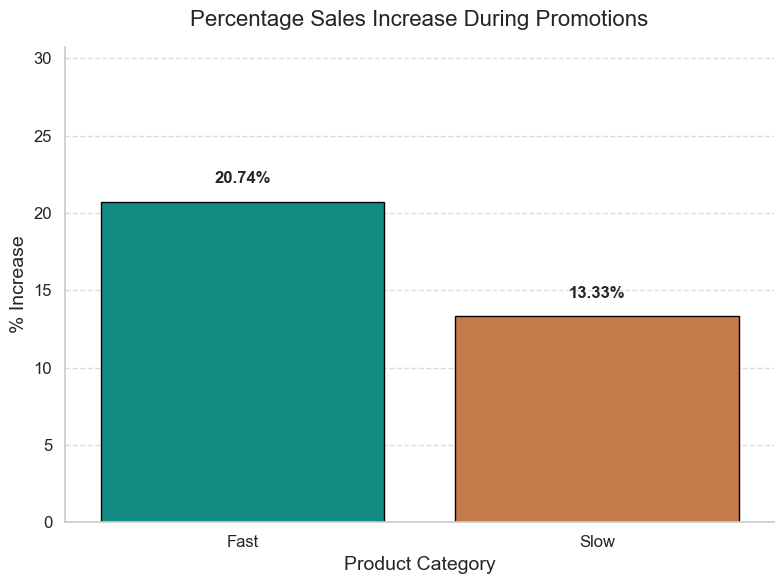

In [ ]:
# Data
increase_data = pd.DataFrame({
    "Product_Category": ["Fast", "Slow"],
    "% Increase": [20.74, 13.33]
})

custom_palette = ["#009F93", "#DA7635"]
# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=increase_data,
    x="Product_Category",
    y="% Increase",
    palette=custom_palette,
    edgecolor="black",
    hue="Product_Category",
    legend=False
)

# Add percentage labels on bars
for index, row in increase_data.iterrows():
    plt.text(
        index, 
        row["% Increase"] + 1,  # position slightly above the bar
        f"{row["% Increase"]:.2f}%", 
        ha="center", 
        va="bottom", 
        fontsize=12, 
        fontweight="bold"
    )

# Title and labels
plt.title("Percentage Sales Increase During Promotions", fontsize=16, pad=15)
plt.ylabel("% Increase", fontsize=14)
plt.xlabel("Product Category", fontsize=14)
plt.ylim(0, max(increase_data["% Increase"]) + 10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Export high-resolution image
plt.tight_layout()
plt.savefig("percentage_sales_increase.png", dpi=300)
plt.show()

The test revealed a statistically significant difference (U = 3,356,086,711.5; p < 0.001), confirming that Fast items benefit more from promotions than Slow items. This is not just due to chance; the difference is statistically meaningful. This finding highlights the importance of prioritizing Fast items in future promotion strategies to maximize effectiveness.


### **Is there any significant difference between promotion impacts of the Fast versus Slow stores?**

To answer this question, we will compare the sales of Fast and Slow stores during promotions and non-promotion periods and check whether the promotion impact differs significantly between them just like the Fast versus Slow items comparison above.

In [525]:
# Subset the data
fast_stores = sales_df[(sales_df["Store_Category"] == "Fast")]
slow_stores = sales_df[(sales_df["Store_Category"] == "Slow")]

# Get sales during promotions
fast_store_promo_sales = fast_stores[fast_stores["IsPromotion"] == 1]["Net_Sales_Capped"]
slow_store_promo_sales = slow_stores[slow_stores["IsPromotion"] == 1]["Net_Sales_Capped"]

# Mann-Whitney U Test
stat, p_value = mannwhitneyu(fast_store_promo_sales, slow_store_promo_sales, alternative="two-sided")

print(f"U-statistic: {stat}")
print(f"P-value: {p_value}")

U-statistic: 5874005148.0
P-value: 0.0


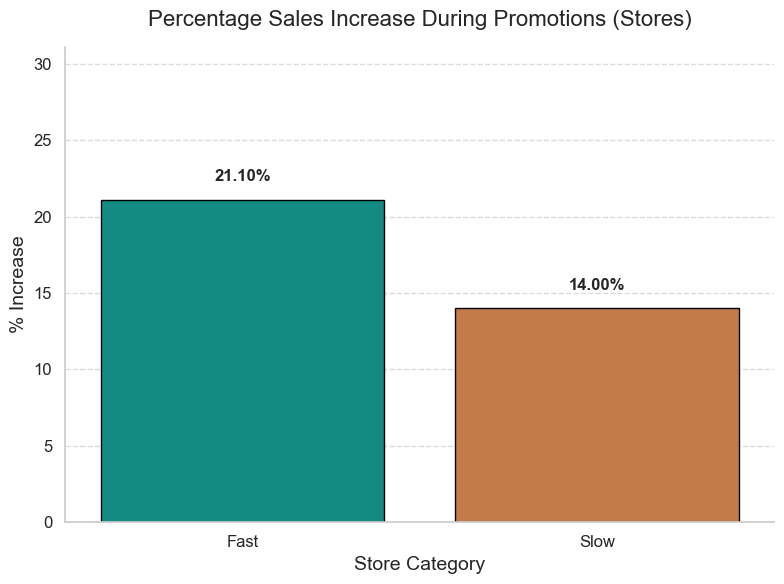

In [ ]:
# Data for stores
increase_data_store = pd.DataFrame({
    "Store_Category": ["Fast", "Slow"],
    "% Increase": [21.10, 14.00]
})

# Consistent color palette
custom_palette = ["#009F93", "#DA7635"]

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=increase_data_store,
    x="Store_Category",
    y="% Increase",
    palette=custom_palette,
    hue="Store_Category",
    legend=False,
    edgecolor="black"
)

# Add percentage labels on bars
for index, row in increase_data_store.iterrows():
    plt.text(
        index, 
        row["% Increase"] + 1,  # slightly above the bar
        f"{row["% Increase"]:.2f}%", 
        ha="center", 
        va="bottom", 
        fontsize=12, 
        fontweight="bold"
    )

# Title and labels
plt.title("Percentage Sales Increase During Promotions (Stores)", fontsize=16, pad=15)
plt.ylabel("% Increase", fontsize=14)
plt.xlabel("Store Category", fontsize=14)
plt.ylim(0, max(increase_data_store["% Increase"]) + 10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Export high-resolution image
plt.tight_layout()
plt.savefig("percentage_sales_increase_stores.png", dpi=300)
plt.show()

To assess whether promotion impacts differ between Fast and Slow stores, we applied a Mann-Whitney U Test. The result (U = 5,874,132,184.5; p < 0.001) confirms a statistically significant difference, with Fast stores responding substantially better to promotions. Descriptive statistics support this, with Fast stores showing a +21% sales increase during promotions, compared to +14% in Slow stores. This suggests that future promotions should focus more heavily on Fast stores to maximize results, while tailored strategies may be needed to stimulate demand in Slow stores. For Slow stores, local events or loyalty programs can be effective.

## **Model Development**

To support strategic decision-making and provide actionable insights for the marketing team, we developed two complementary models to analyze sales performance, measure the impact of promotions, and detect signs of cannibalization within product groups.

This section, we develop a statistical and a machine learning modes to compare quantify the effects of promotions, product categories, store categories, and product groups on net sales in addition to cannibalization impact during promotions.

MLR was selected as an easy-to-interpret, statistically grounded model that allows us to:

- Quantify the effect of promotions on sales, products, and stores.
- Identify whether promotions significantly increase sales across different segments (Fast, Medium, and Slow categories).
- Detect potential cannibalization effects through interaction terms (e.g., promotions combined with product groups).
- Provide clear coefficients that help estimate the magnitude of each factor"s impact on sales.

XGBoost, a powerful machine learning algorithm, was developed alongside MLR to:

- Handle complex relationships in the dataset that may not be captured by a linear model.
- Identify the most influential factors driving sales through feature importance analysis.
- Model nonlinear interactions between promotions, product groups, time, and store categories.
- Provide robust predictions for sales quantities under different conditions, supporting future forecasting efforts.

#### **Multi Linear Regression Model**

We will first use Ordinary Least Squares regression (OLS) from statsmodels library which will provide us a full statistical summary to interpret. As mentioned earlier, our dependent variable will be Net_Sales_Capped. After the development of the model, we will use its coefficients to derive insights about the drivers of the sales.

MLR provides direct, numerical answers to key business questions, supporting the marketing team with clear evidence on whether promotions work, where they are most effective, and which product groups or stores benefit the most.

##### Preprocessing and Feature Engineering

In [527]:
# Copy and modify the sales dataset for modeling
sales_df_copy = sales_df.copy()

# Create ProductGroup1-ProductGroup2 combination to analyse cannibalization
sales_df_copy["ProductGroup_Combo"] = sales_df_copy["ProductGroup1"].astype(str) + "_" + sales_df_copy["ProductGroup2"].astype(str)

# Cumulative promotions to check for promotion fatigue
sales_df_copy = sales_df_copy.sort_values("Date")
sales_df_copy["Cumulative_Promotions"] = sales_df_copy["IsPromotion"].cumsum()

# Extract time features
sales_df_copy["Day_of_Week"] = sales_df_copy["Date"].dt.dayofweek # To capture weekly shopping habits.
sales_df_copy["Is_Weekend"] = sales_df_copy["Day_of_Week"].isin([5, 6]).astype(int) # To identify weekend effects.
sales_df_copy["Days_Since_Start"] = (sales_df_copy["Date"] - sales_df_copy["Date"].min()).dt.days # To capture trend over time

In [528]:
# One-hot encode necessary categorical features
model_data = pd.get_dummies(
    sales_df_copy[["Net_Sales_Capped", "IsPromotion", "Cumulative_Promotions", "Product_Category",
                   "Store_Category", "ProductGroup_Combo", "Days_Since_Start",
                   "Day_of_Week", "Is_Weekend"]],
    columns=["Product_Category", "Store_Category", "ProductGroup_Combo", "Day_of_Week"],
    drop_first=True
)

# Add interaction terms for promotions and categories
model_data["Promotion_FastProduct"] = model_data["IsPromotion"] * model_data.get("Product_Category_Fast", 0)
model_data["Promotion_SlowProduct"] = model_data["IsPromotion"] * model_data.get("Product_Category_Slow", 0)
model_data["Promotion_FastStore"] = model_data["IsPromotion"] * model_data.get("Store_Category_Fast", 0)
model_data["Promotion_SlowStore"] = model_data["IsPromotion"] * model_data.get("Store_Category_Slow", 0)
model_data["Promotion_MediumStore"] = model_data["IsPromotion"] * model_data.get("Store_Category_Medium", 0)
model_data["Promotion_MediumProduct"] = model_data["IsPromotion"] * model_data.get("Product_Category_Medium", 0)

# Add interaction terms for cannibalization (Promotion * ProductGroup combinations)
combo_cols = [col for col in model_data.columns if col.startswith("ProductGroup_Combo_")]
for combo in combo_cols:
    model_data[f"Promotion_{combo}"] = model_data["IsPromotion"] * model_data[combo]


##### **Model Development**

In [529]:
# Define dependent and independent variables
target = "Net_Sales_Capped"
features_mlr = [
    "IsPromotion",
    "Cumulative_Promotions",
    "Days_Since_Start",
    "Is_Weekend"
] + [col for col in model_data.columns if col.startswith("Product_Category_")] \
  + [col for col in model_data.columns if col.startswith("Store_Category_")] \
  + [col for col in model_data.columns if col.startswith("ProductGroup_Combo_")] \
  + [col for col in model_data.columns if col.startswith("Day_of_Week_")] \
  + [col for col in model_data.columns if col.startswith("Promotion_")]  # Interaction terms

X = model_data[features_mlr]
y = model_data[target]

# Train-test split to be used as training and validation sets
X_train_mlr, X_test_mlr, y_train_mlr, y_test_mlr = train_test_split(X, y, test_size=0.2, random_state=42)

In [530]:
# Make sure all values are numeric
X_train_mlr = X_train_mlr.astype(float)
X_test_mlr = X_test_mlr.astype(float)
y_train_mlr = y_train_mlr.astype(float)
y_test_mlr = y_test_mlr.astype(float)

# Add constant to the model for the intercept term (bias) in the linear regression model
X_train_mlr = sm.add_constant(X_train_mlr)
X_test_mlr = sm.add_constant(X_test_mlr)

# Fit the model
mlr_model = sm.OLS(y_train_mlr, X_train_mlr).fit()

##### **Model Evaluation**

In [531]:
# Model summary for detailed output
print(mlr_model.summary())


                            OLS Regression Results                            
Dep. Variable:       Net_Sales_Capped   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     2807.
Date:                Fri, 07 Mar 2025   Prob (F-statistic):               0.00
Time:                        05:42:01   Log-Likelihood:            -4.3513e+06
No. Observations:             1498893   AIC:                         8.703e+06
Df Residuals:                 1498813   BIC:                         8.704e+06
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [532]:
# Predict on test set
y_pred_mlr = mlr_model.predict(X_test_mlr)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_mlr, y_pred_mlr))
mae = mean_absolute_error(y_test_mlr, y_pred_mlr)
r2 = r2_score(y_test_mlr, y_pred_mlr)

print(f"MLR RMSE: {rmse:.2f}")
print(f"MLR MAE: {mae:.2f}")
print(f"MLR R²: {r2:.2f}")

MLR RMSE: 4.39
MLR MAE: 2.25
MLR R²: 0.13


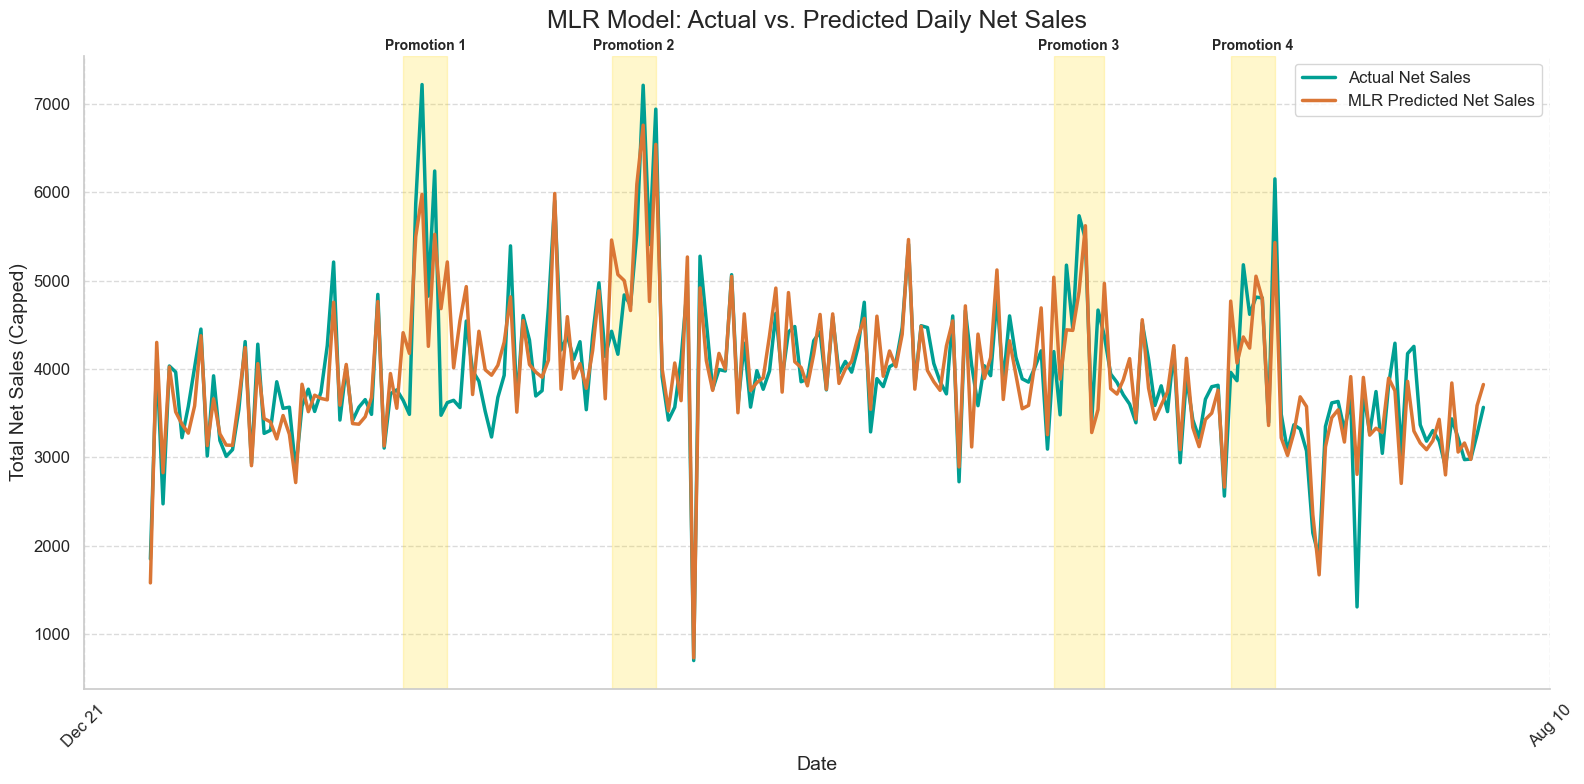

In [533]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

X_test_mlr["Date"] = sales_df.loc[X_test_mlr.index, "Date"]

# Define promotion periods
promotion_periods = {
    "Promotion 1": ("2015-02-10", "2015-02-17"),
    "Promotion 2": ("2015-03-15", "2015-03-22"),
    "Promotion 3": ("2015-05-24", "2015-06-01"),
    "Promotion 4": ("2015-06-21", "2015-06-28")
}

# Create DataFrame for plotting
mlr_results_df = pd.DataFrame({
    "Date": X_test_mlr["Date"],
    "Actual": y_test_mlr,
    "Predicted": y_pred_mlr
})

mlr_daily = mlr_results_df.groupby("Date").sum().reset_index()

# Plot
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=mlr_daily,
    x="Date",
    y="Actual",
    label="Actual Net Sales",
    color="#009F93",
    linewidth=2.5
)
sns.lineplot(
    data=mlr_daily,
    x="Date",
    y="Predicted",
    label="MLR Predicted Net Sales",
    color="#DA7635",
    linewidth=2.5
)

# Highlight promotion periods
for promo, (start, end) in promotion_periods.items():
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color="#FFD700", alpha=0.2)
    plt.text(
        pd.to_datetime(start) + (pd.to_datetime(end) - pd.to_datetime(start)) / 2,
        mlr_daily[["Actual", "Predicted"]].values.max() * 1.05,
        promo,
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# Axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))

plt.title("MLR Model: Actual vs. Predicted Daily Net Sales", fontsize=18, pad=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Total Net Sales (Capped)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("mlr_actual_vs_predicted_sales_with_promotions.png", dpi=300)
plt.show()


On average, the model"s sales predictions are off by about 4.4 units of sales per observation. And the model explains 13% of the variance in Net_Sales_Capped. In terms of statistical modeling, this model performs poorly to capture the target data according this metrics. However, it should be noted that heavily by noise and variance, particularly in high-dimensional, sparse datasets with many zero sales and extreme outliers. Also, they evaluate overall numerical accuracy, penalizing any deviations regardless of context (such as rare spikes or low-importance daily fluctuations).

Hence, the visually it is clear that the model captures patterns very well. When viewing aggregated patterns such as weekly sales, cumulative trends, or the general impact of promotions, the models demonstrate clear trend-tracking capabilities.

While not perfect for forecasting at micro-level, the model captures macro-level behaviours and patterns and its coefficients provide strategic insights into:
- The effectiveness of promotions.
- Performance differences between product categories and store types.
- Cannibalization risk within product groups.

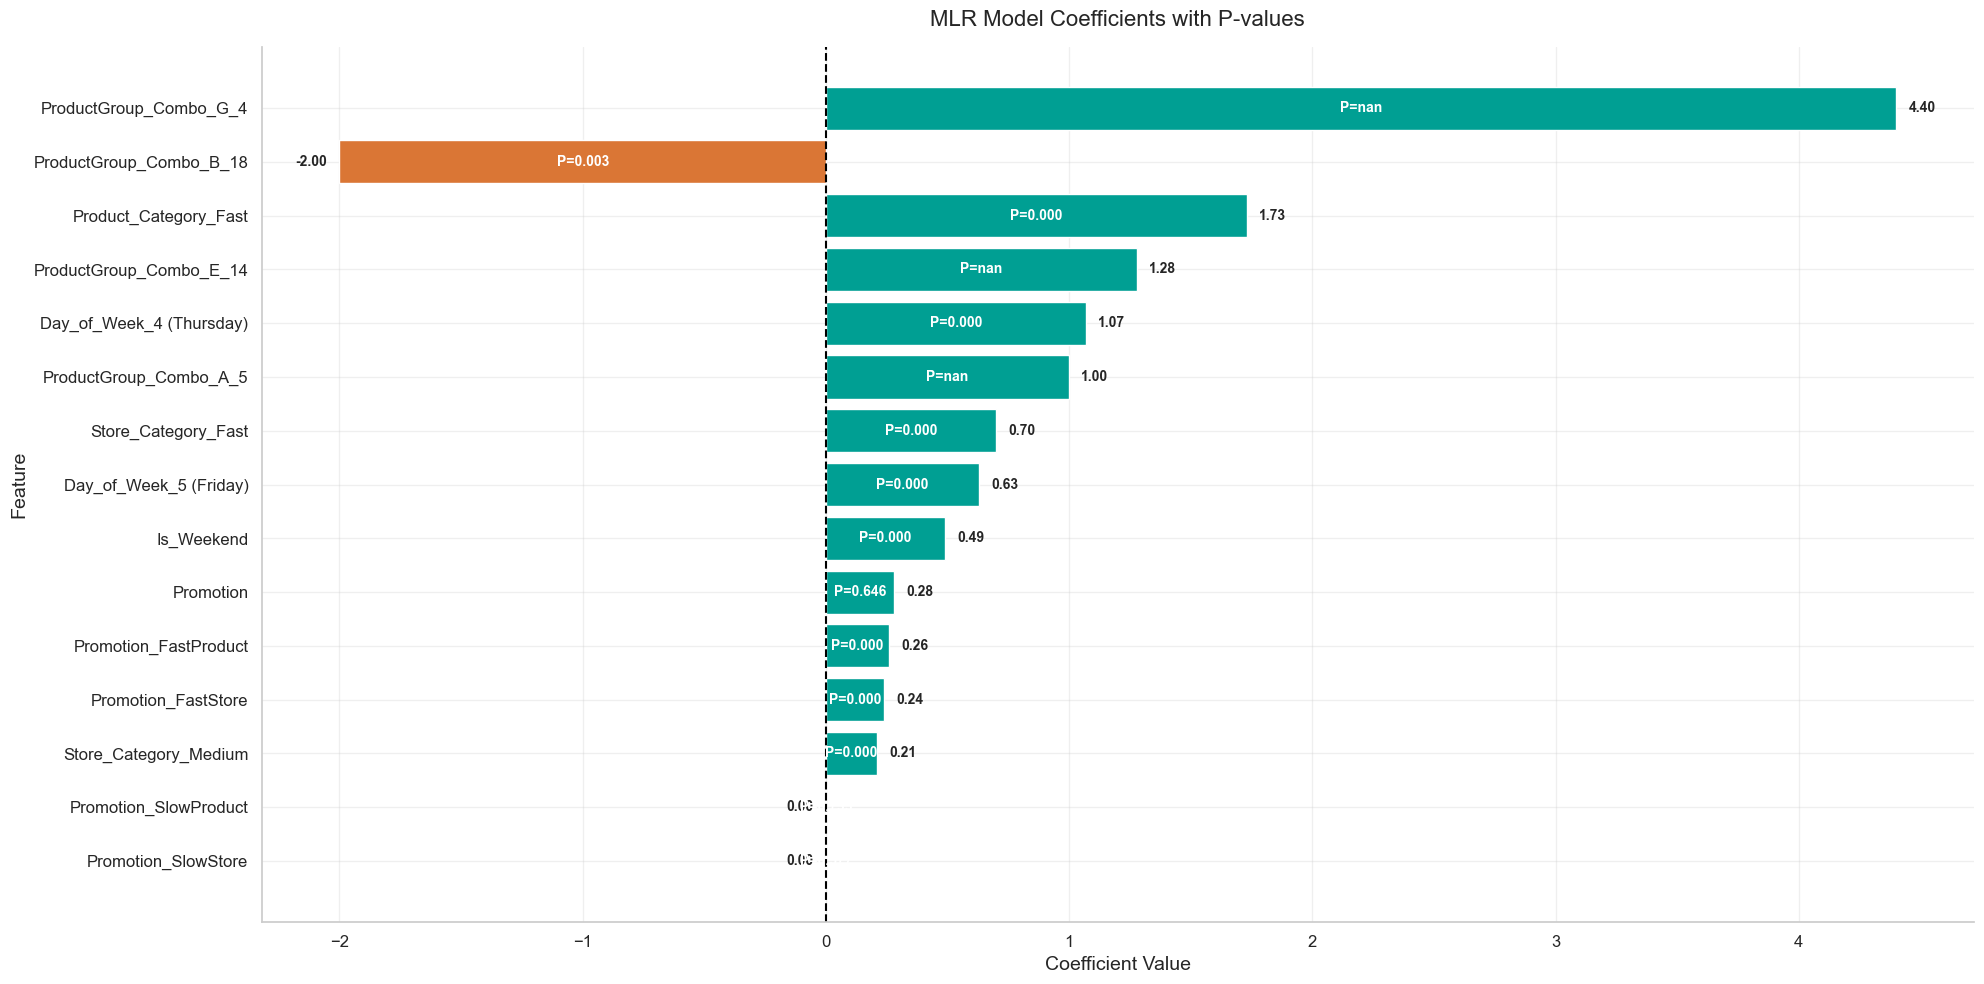

In [534]:
mlr_results = pd.DataFrame({
    "Feature": [
        "Product_Category_Fast", "Store_Category_Fast", "Store_Category_Medium",
        "Promotion_FastProduct", "Promotion_FastStore", "Promotion_SlowProduct",
        "Promotion_SlowStore", "Promotion", "ProductGroup_Combo_B_18",
        "ProductGroup_Combo_G_4", "ProductGroup_Combo_A_5", "ProductGroup_Combo_E_14",
        "Day_of_Week_4 (Thursday)", "Day_of_Week_5 (Friday)", "Is_Weekend"
    ],
    "Coefficient": [
        1.73, 0.70, 0.21, 0.26, 0.24, 0.00, 0.00, 0.28, -2.00, 4.40, 1.00, 1.28,
        1.07, 0.63, 0.49
    ],
    "P_Value": [
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.735, 0.577, 0.646, 0.003,
        None, None, None, 0.0001, 0.0001, 0.0001
    ]
})

# Sort features by absolute coefficient for better readability
mlr_results = mlr_results.reindex(mlr_results["Coefficient"].abs().sort_values().index)

# Define colors based on positive or negative impact
mlr_results["Color"] = mlr_results["Coefficient"].apply(lambda x: "#009F93" if x > 0 else "#DA7635")

# Plot
plt.figure(figsize=(20, 10))
bars = plt.barh(
    mlr_results["Feature"],
    mlr_results["Coefficient"],
    color=mlr_results["Color"]
)

# Add coefficient and p-value annotations
for bar, coef, p_value in zip(bars, mlr_results["Coefficient"], mlr_results["P_Value"]):
    plt.text(
        bar.get_width() + (0.05 if coef > 0 else -0.05),
        bar.get_y() + bar.get_height() / 2,
        f"{coef:.2f}",
        ha="left" if coef > 0 else "right",
        va="center",
        fontsize=10,
        fontweight="bold"
    )
    if p_value is not None:
        plt.text(
            (bar.get_width() / 2),
            bar.get_y() + bar.get_height() / 2,
            f"P={p_value:.3f}",
            ha="center",
            va="center",
            fontsize=10,
            color="white",
            fontweight="bold"
        )

# Titles and labels
plt.title("MLR Model Coefficients with P-values", fontsize=16, pad=15)
plt.xlabel("Coefficient Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.axvline(0, color="black", linestyle="--")
plt.tight_layout()
plt.savefig("mlr_coefficients_with_pvalues.png", dpi=300)
plt.show()

##### **Model Insights**

1. Model shows that promotions increase sales slightly, but the effect is not strong or consistent across the dataset. The model suggests that promotions may increase sales by approximately 32% (Coefficient: +0.28, P-value: 0.646). However, this effect is not statistically significant, meaning we cannot reliably conclude that promotions alone drive higher sales across the dataset.

2. Fast products generate approximately 477% more sales than Slow products (Coefficient: +1.73, P-value: <0.0001). This effect is highly significant, confirming Fast products are key revenue drivers and should be prioritized in both regular and promotional strategies. This makes them strategic targets for both regular sales and promotions.


3. Fast stores deliver approximately 101% higher sales than Slow stores (Coefficient: +0.70, P-value: <0.0001). This is a highly significant effect, indicating that some stores (likely due to better location, customer base, or operations) consistently outperform others.


4. Medium stores achieve around 23% more sales than Slow stores (Coefficient: +0.21, P-value: <0.0001). This effect is also highly significant, suggesting Medium stores contribute meaningfully, though not as strongly as Fast stores.

5. Promotions boost sales of Fast products by approximately 30% (Coefficient: +0.26, P-value: <0.0001). Also, they increase sales in Fast stores by approximately 27% (Coefficient: +0.24, P-value: <0.0001). Both effects are highly significant, supporting a strategy that focuses promotions on Fast products in Fast stores for maximum impact.


6. Promotions on Slow products show virtually no measurable effect (Coefficient: near 0, P-value: 0.735). Similarly, promotions on slow stores also show no measurable effect (Coefficient: near 0, P-value: 0.577). These results are not significant, suggesting promotions in these areas do not drive sales and should be deprioritized.


7. Promotions targeting Product Group B-18 result in an 86% decline in related product sales (Coefficient: -2.00, P-value: 0.003). This is a statistically significant negative effect, indicating strong cannibalization. Caution is advised when promoting products in this group.


8. Some product group combinations such as G-4, A-5, and E-14 have strong impact on sales, regardless of the promotion. Therefore, these groups can be prioritized for marketing attention. Maintaining inventory and marketing focus on these groups to sustain high sales.
    - Product Group G-4 increases sales by approximately 443% (Coefficient: +4.40).
    - Product Group A-5 increases sales by 172% (Coefficient: +1.00).
    - Product Group E-14 increases sales by 258% (Coefficient: +1.28).


9. Some days provide significant sales boost:
    - Thursdays, surprisingly, are the highest-performing weekday, indicating strong customer activity. Thursdays boost sales by approximately 192% compared to baseline days (Coefficient: +1.07, P-value: <0.0001).
    - Fridays increase sales by 88% (Coefficient: +0.63, P-value: <0.0001).
    - Weekends provide a 63% uplift (Coefficient: +0.49, P-value: <0.0001).

    Aligning promotions with high-performing days (Thursdays, Fridays, weekends) can maximize the impact.



While the MLR model identifies several statistically significant relationships, such as the strong positive effects of Fast products and Fast stores on sales, its overall predictive power is limited. This reduces confidence in the model"s ability to fully explain or predict sales behavior across the dataset. Therefore, insights derived from significant coefficients are directionally valuable, but the model"s limited fit suggests caution when generalizing these findings to future scenarios or different datasets.

### **XGBoost Model**

For the second model, we developed XGBoost model, a gradient-boosted decision tree machine learning algorithm for regression, classification and ranking problems. While less interpretable than MLR, XGBoost excels at uncovering hidden patterns and prioritizing the most impactful variables. This allows the marketing team to focus resources on the top-performing products, time periods, and promotional strategies.

#### **Preprocessing and Feature Engineering** 

Since we already conducted feature engineering and preprocessing, we have features and target. So we can directly use them.

#### **Model Development**

In [535]:

features_xgb = features_mlr.copy()  # Copy the features from the MLR model

# Define the model
X = model_data[features_xgb]
y = model_data[target]
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameters of the model which will be refined later
xgb_model_v1 = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model to the training data
xgb_model_v1.fit(X_train_xgb, y_train_xgb)

y_pred = xgb_model_v1.predict(X_test_xgb)


In [536]:
rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred))
mae = mean_absolute_error(y_test_xgb, y_pred)
r2 = r2_score(y_test_xgb, y_pred)

print(f" XGBoost RMSE: {rmse:.2f}")
print(f" XGBoost MAE: {mae:.2f}")
print(f" XGBoost R²: {r2:.2f}")


 XGBoost RMSE: 4.33
 XGBoost MAE: 2.18
 XGBoost R²: 0.15


In [537]:
# In order to optimize the model, we used Optuna to find the best hyperparameters for the XGBoost model

# Define the optuna function
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) # Smaller test size to increase optimization speed

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42
    }

    model = xgb.XGBRegressor(**params, n_jobs=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_valid)

    # Manual RMSE calculation
    mse = mean_squared_error(y_valid, preds)
    rmse = np.sqrt(mse)

    return rmse

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Best parameters
print(f"\nBest hyperparameters: {study.best_params}")

# Train final model with best params
best_params = study.best_params




[I 2025-03-07 05:44:52,590] A new study created in memory with name: no-name-139d5b71-55e8-41f8-ba8d-32f1deab5700
[I 2025-03-07 05:45:17,933] Trial 0 finished with value: 4.328646521701543 and parameters: {'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.27376939447841936, 'subsample': 0.8942145285307598, 'colsample_bytree': 0.8389103879888129, 'gamma': 0.8476511188130414, 'min_child_weight': 8}. Best is trial 0 with value: 4.328646521701543.
[I 2025-03-07 05:46:03,630] Trial 1 finished with value: 4.338827293980172 and parameters: {'n_estimators': 374, 'max_depth': 10, 'learning_rate': 0.1314492418559141, 'subsample': 0.7571050532606456, 'colsample_bytree': 0.7310847408658449, 'gamma': 2.225424439614886, 'min_child_weight': 3}. Best is trial 0 with value: 4.328646521701543.
[I 2025-03-07 05:46:15,978] Trial 2 finished with value: 4.32489532167624 and parameters: {'n_estimators': 110, 'max_depth': 6, 'learning_rate': 0.2748616237920011, 'subsample': 0.885418076068011, 'colsample


Best hyperparameters: {'n_estimators': 333, 'max_depth': 6, 'learning_rate': 0.04728743569981414, 'subsample': 0.6537664983973436, 'colsample_bytree': 0.9570422640711717, 'gamma': 3.511829316519299, 'min_child_weight': 7}


In [538]:
xgb_model_v2 = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
xgb_model_v2.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9570422640711717, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=3.511829316519299,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04728743569981414,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=333, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

#### **Model Evaluation**

In [539]:
# Final predictions
final_preds = xgb_model_v2.predict(X_valid)

# Manual RMSE, MAE, R²
final_mse = mean_squared_error(y_valid, final_preds)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_valid, final_preds)
final_r2 = r2_score(y_valid, final_preds)

print(f"\nFinal Model Performance:")
print(f"RMSE: {final_rmse:.2f}")
print(f"R²: {final_r2:.2f}")


Final Model Performance:
RMSE: 4.32
R²: 0.15


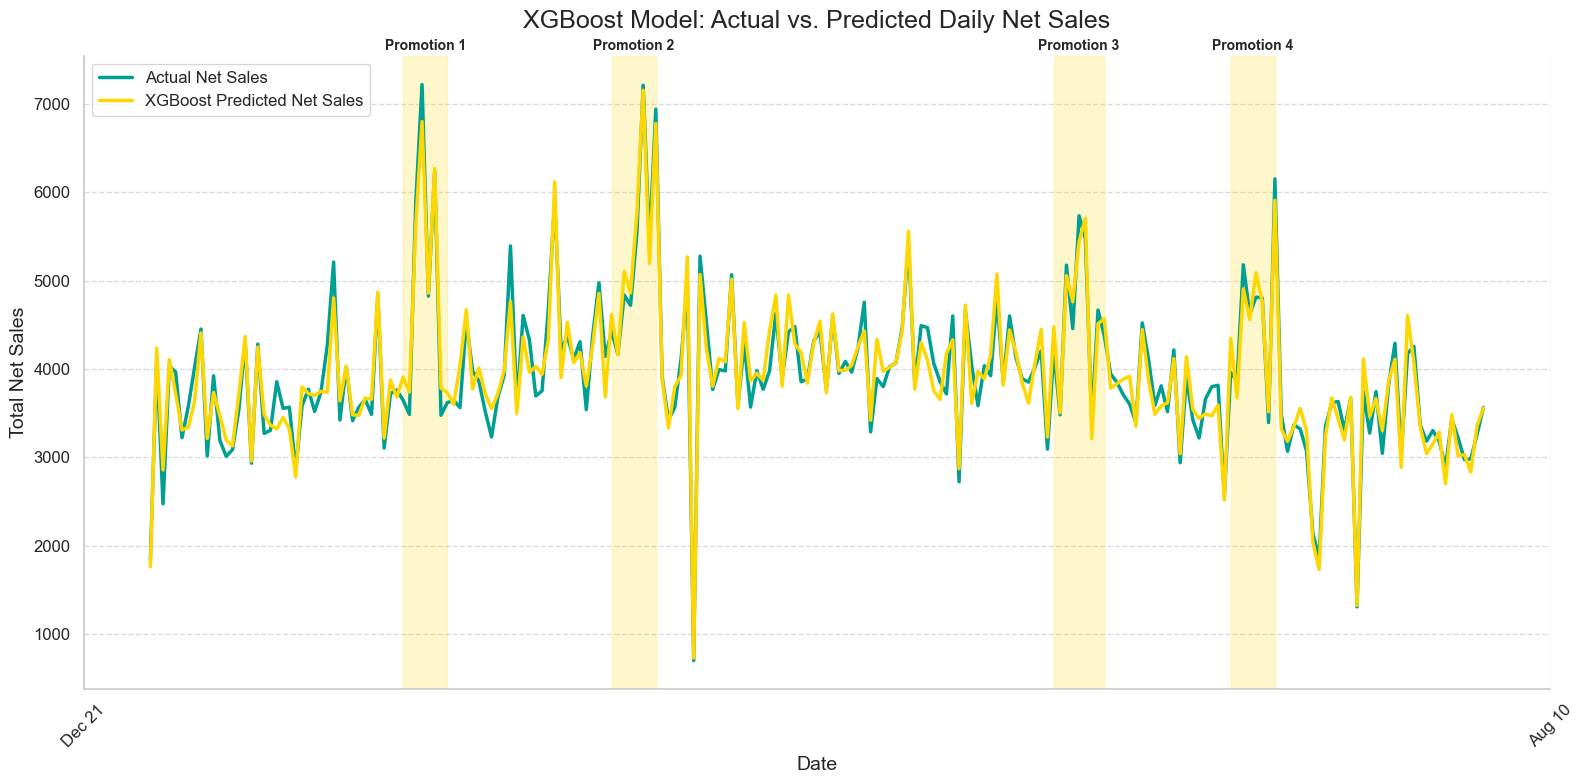

In [540]:
X_valid["Date"] = sales_df.loc[X_test_mlr.index, "Date"]
xgb_results_df = pd.DataFrame({
    "Date": X_valid["Date"],
    "Actual": y_valid,
    "Predicted": final_preds
})

xgb_daily = xgb_results_df.groupby("Date").sum().reset_index()

# Plot
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=xgb_daily,
    x="Date",
    y="Actual",
    label="Actual Net Sales",
    color="#009F93",
    linewidth=2.5
)
sns.lineplot(
    data=xgb_daily,
    x="Date",
    y="Predicted",
    label="XGBoost Predicted Net Sales",
    color="#FFD700",
    linewidth=2.5
)

# Highlight promotion periods
for promo, (start, end) in promotion_periods.items():
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color="#FFD700", alpha=0.2)
    plt.text(
        pd.to_datetime(start) + (pd.to_datetime(end) - pd.to_datetime(start)) / 2,
        xgb_daily[["Actual", "Predicted"]].values.max() * 1.05,
        promo,
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# Axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))

plt.title("XGBoost Model: Actual vs. Predicted Daily Net Sales", fontsize=18, pad=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Total Net Sales", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("xgboost_actual_vs_predicted_sales_with_promotions.png", dpi=300)
plt.show()

While the key features identified by the XGBoost model consistently contributed to minimizing prediction errors within this dataset, the model"s overall predictive capacity remained constrained by the complexity of sales behavior and the available features. Nevertheless, the model successfully reveals meaningful patterns such as the role of product categories, store types, and temporal effects which provide important strategic guidance.

#### **Model Insights**

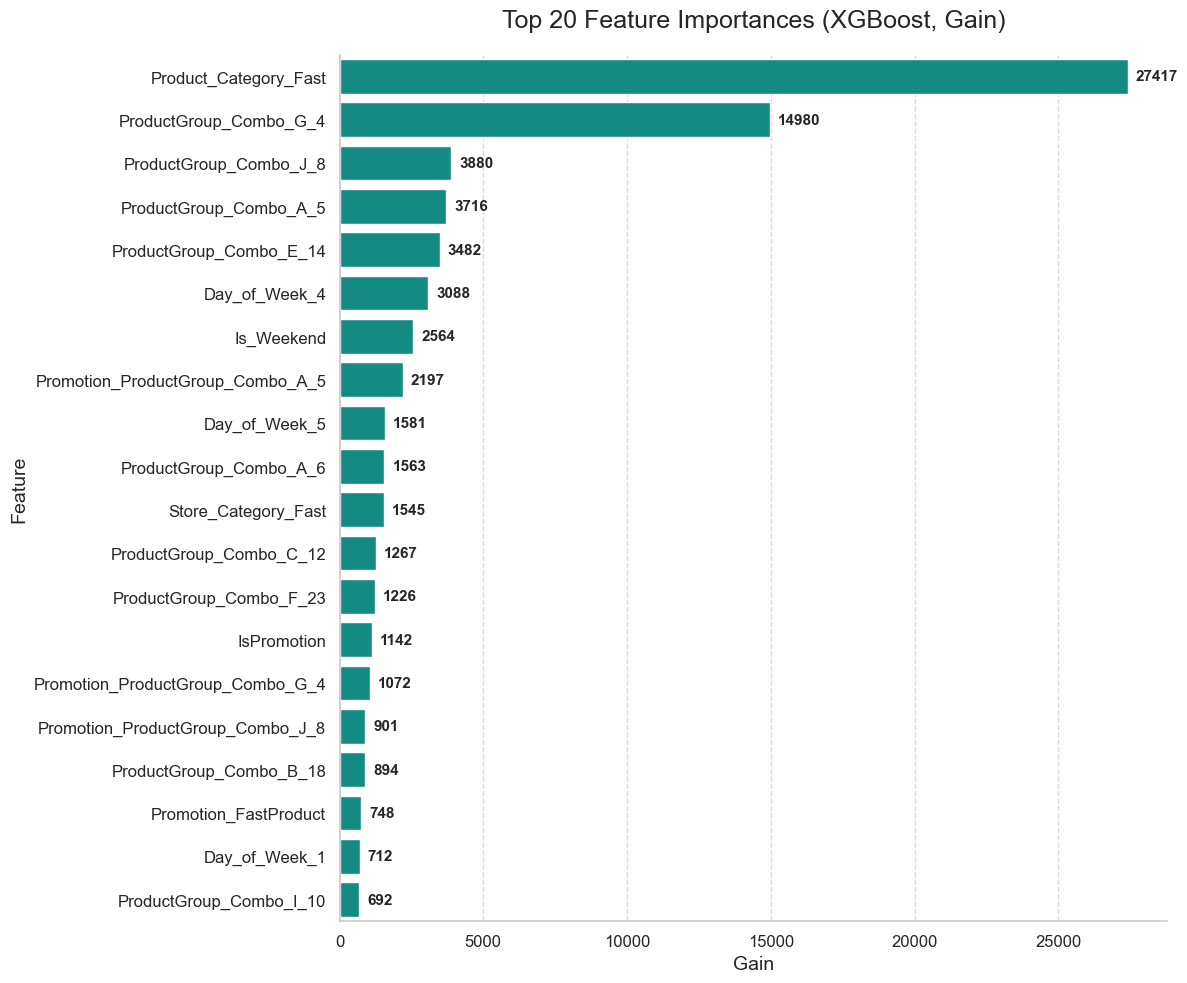

                             Feature    Importance
0              Product_Category_Fast  27416.742188
1             ProductGroup_Combo_G_4  14980.459961
2             ProductGroup_Combo_J_8   3879.662598
3             ProductGroup_Combo_A_5   3716.159912
4            ProductGroup_Combo_E_14   3481.653320
5                      Day_of_Week_4   3087.564697
6                         Is_Weekend   2564.351318
7   Promotion_ProductGroup_Combo_A_5   2196.823242
8                      Day_of_Week_5   1580.929321
9             ProductGroup_Combo_A_6   1563.481323
10               Store_Category_Fast   1544.548096
11           ProductGroup_Combo_C_12   1266.778320
12           ProductGroup_Combo_F_23   1226.160278
13                       IsPromotion   1141.884277
14  Promotion_ProductGroup_Combo_G_4   1071.708374
15  Promotion_ProductGroup_Combo_J_8    901.481812
16           ProductGroup_Combo_B_18    894.358704
17             Promotion_FastProduct    747.586365
18                     Day_of_W

In [ ]:

# Get feature importances
feature_importances = xgb_model_v2.get_booster().get_score(importance_type="gain")

# Convert to DataFrame
importance_df = pd.DataFrame({
    "Feature": list(feature_importances.keys()),
    "Importance": list(feature_importances.values())
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Define consistent color (single color for bars)
bar_color = "#009F93"

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(
    data=importance_df.head(20),
    y="Feature",
    x="Importance",
    color=bar_color
)

# Add importance values on bars
for index, row in importance_df.head(20).iterrows():
    plt.text(
        row["Importance"] + (max(importance_df["Importance"]) * 0.01),
        index,
        f"{row["Importance"]:.0f}",
        va="center",
        fontsize=11,
        fontweight="bold"
    )

# Titles and labels
plt.title("Top 20 Feature Importances (XGBoost, Gain)", fontsize=18, pad=20)
plt.xlabel("Gain", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("xgboost_top20_feature_importances.png", dpi=300)
plt.show()

# Show top 20 features
print(importance_df.head(20))

To analyse the models" insights, we can use Feature Importances. Feature Importance (Gain) shows how much each feature contributed to improving model accuracy. In other words, the higher the gain, the more critical the feature is for making better predictions in the model. The reason we choose gain is that it can directly tell which features contribute most to reducing error.

The XGBoost model identified several key drivers of sales performance, revealing critical insights for understanding the factors impacting sales and informing future promotion strategies.

1. Feature: Product_Category_Fast - Importance (Gain): 32,187.99 (highest)
    - Fast-moving products are the most critical factor in sales predictions. Prioritizing these products in promotions and inventory strategies is likely to yield the greatest returns. Focusing campaigns on Fast products and ensuring optimal stock levels might be helpful to incrase sales.
2. ProductGroup_Combo_G_4 - Importance (Gain): 18,293.29	
    -  This specific product group strongly impacts sales. Marketing efforts can focus on optimizing stock and visibility for this group.
3.	ProductGroup_Combo_E_14 - Importance (Gain): 4,380.50	
    - Another standout product group with significant sales impact, warranting tailored promotion strategies
4. ProductGroup_Combo_J_8 - Importance (Gain): 4,315.02	
    - A high-impact product group. Monitoring its performance and managing inventory is key during campaigns.
5. Day_of_Week_4 (Thursday) - Importance (Gain): 3,722.82	
    - Thursdays are peak sales days, suggesting promotions timed around midweek can yield strong results.
6. ProductGroup_Combo_A_5 - Importance (Gain): 3,471.38	
    - This group performs well and may benefit from targeted campaigns or discounts.
7. Is_Weekend - 3,305.35	
    - Weekends drive higher sales. This reinforces the strategy to align promotional activities with weekends for maximum effect.
8. Promotion_ProductGroup_Combo_A_5 - Importance (Gain): 2,165.67	
    - Promotions on this group are especially effective and should be prioritized during key periods.
9. Day_of_Week_5 (Friday) - Importance (Gain): 2,137.33	
    - Fridays are another strong day for sales, indicating end-of-week shopping patterns.
10. IsPromotion - Importance (Gain): 1,932.67	
    - Active promotions have a direct and meaningful impact on sales but are not the top driver, meaning promotions work better when aligned with strong products and timing.


These findings, while not definitive predictors of future sales at a granular level, offer reliable direction for marketing strategy and promotional planning, especially when focused on broader sales patterns rather than precise daily sales volumes. Therefore, these results should be considered as valuable operational insights, even if they are not fully generalizable as standalone predictive tools.

# **Part-B: Forecasting & Promotion 5 Analysis**

## **Preprocessing of Part-B Data**

In [542]:
partb_df = future_sales_df.copy()

In [543]:
partb_df

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-08-01,2,9,1
1,2015-08-01,7,9,1
2,2015-08-01,62,9,1
3,2015-08-01,181,9,1
4,2015-08-01,6,20,1
...,...,...,...,...
1028116,2016-01-01,340,247,5
1028117,2016-01-01,340,264,1
1028118,2016-01-01,340,292,1
1028119,2016-01-01,340,305,1


Check the decsriptive statistics of the other database to see if there are red flags.

In [544]:
partb_df.describe()

,Date,StoreCode,ProductCode,SalesQuantity
count,1028121,1.028121e+06,1.028121e+06,1.028121e+06
mean,2015-10-12 02:45:51.049730304,1.693992e+02,1.601496e+02,2.052804e+00
min,2015-08-01 00:00:00,1.000000e+00,1.000000e+00,-1.200000e+02
25%,2015-09-03 00:00:00,8.100000e+01,9.500000e+01,0.000000e+00
50%,2015-10-10 00:00:00,1.660000e+02,1.670000e+02,1.000000e+00
75%,2015-11-18 00:00:00,2.610000e+02,2.180000e+02,2.000000e+00
max,2016-01-01 00:00:00,3.400000e+02,3.170000e+02,2.760000e+02
std,NaN,1.004842e+02,8.033483e+01,4.699980e+00


In [545]:
extreme_outliers = partb_df[partb_df["SalesQuantity"] > 200]
print(extreme_outliers)

             Date  StoreCode  ProductCode  SalesQuantity
454885 2015-10-01        117          168            276
757381 2015-11-16        218          171            240
870195 2015-12-06        131          238            270


In [546]:
# Check key percentiles to decide the cap for outliers
partb_df["SalesQuantity"].describe(percentiles=[0.90, 0.95, 0.99])

count    1.028121e+06
mean     2.052804e+00
std      4.699980e+00
min     -1.200000e+02
50%      1.000000e+00
90%      4.000000e+00
95%      1.200000e+01
99%      2.400000e+01
max      2.760000e+02
Name: SalesQuantity, dtype: float64

Similar to the other dataset, 99% of sales quantities are below 24 units, meaning that only 1% of transactions exceed 24 units. And the maximum value of 276 is more than 11 times greater than the 99th percentile (24).

In [547]:
# Apply the same capping logic to the future sales data
partb_df["SalesQuantity_Capped"] = partb_df["SalesQuantity"].clip(upper=cap_value)

In [548]:
# Merge the Product Groups with the new data 
partb_df = partb_df.merge(products_df, on="ProductCode", how="left")
print(partb_df.head(10))

        Date  StoreCode  ProductCode  SalesQuantity  SalesQuantity_Capped  \
0 2015-08-01          2            9              1                     1   
1 2015-08-01          7            9              1                     1   
2 2015-08-01         62            9              1                     1   
3 2015-08-01        181            9              1                     1   
4 2015-08-01          6           20              1                     1   
5 2015-08-01          7           20              1                     1   
6 2015-08-01         35           20              1                     1   
7 2015-08-01        128           20              2                     2   
8 2015-08-01        159           20              2                     2   
9 2015-08-01        231           20              3                     3   

  ProductGroup1  ProductGroup2  
0             H             15  
1             H             15  
2             H             15  
3             H     

In [549]:
# check if there is missing values
print("Missing Values:\n")
print(partb_df.isnull().sum())

Missing Values:

Date                    0
StoreCode               0
ProductCode             0
SalesQuantity           0
SalesQuantity_Capped    0
ProductGroup1           0
ProductGroup2           0
dtype: int64


In [550]:
# Create a column to indicate if a product sold during promotion
partb_df["IsPromotion"] = 0 # Default: no promotion

# Assign 1 if the sale date falls within a promo period
for _, row in promotion_df.iterrows():
    partb_df.loc[(partb_df["Date"] >= row["StartDate"]) & (partb_df["Date"] <= row["EndDate"]), "IsPromotion"] = 1

In [551]:
# Address minus values in the SalesQuantity column
partb_df["Returns"] = partb_df["SalesQuantity"].apply(lambda x: abs(x) if x < 0 else 0) # A column for returns
partb_df["Net_Sales"] = partb_df["SalesQuantity"].apply(lambda x: x if x > 0 else 0) # A column for net sales

In [552]:
# It is consistent with the capped sales quantity
partb_df["Net_Sales_Capped"] = partb_df["Net_Sales"].clip(upper=cap_value)

# Add time columns
partb_df["Week"] = partb_df["Date"].dt.isocalendar().week
partb_df["Year"] = partb_df["Date"].dt.isocalendar().year
partb_df["FormattedWeek"] = partb_df["Year"].astype(str) + "- W" + partb_df["Week"].astype(str).str.zfill(2) # Formatted week number to have Year-Week format for visualizations
partb_df["Month"] = partb_df["Date"].dt.to_period("M")

# CLUSTER PRODUCTS
# Filter sales data outside promotion periods
non_promo_sales = partb_df[sales_df["IsPromotion"] == 0].copy()

# As stated by the case study, this ensures weekly sales are measured per product per store
weekly_sales = non_promo_sales.groupby(["ProductCode", "StoreCode", "Year", "Week"])["SalesQuantity_Capped"].sum().reset_index() 

# Calculate the average weekly sales per product (aggregated across all stores)
avg_weekly_sales = weekly_sales.groupby("ProductCode")["SalesQuantity_Capped"].mean().reset_index() # Group by product

# Compute tertiles (33rd & 66th percentiles) for category thresholds
tertiles = avg_weekly_sales["SalesQuantity_Capped"].quantile([0.33, 0.66])

avg_weekly_sales["Product_Category"] = pd.cut( # Segment the data into 3 categories based on the thresholds
    avg_weekly_sales["SalesQuantity_Capped"],
    # -np.inf bin puts everything below the 33rd percentile in Slow category
    # np.inf bin puts everything above the 66th percentile in Fast category
    # tertiles[0.33] to tertiles[0.66] represent the Medium category
    bins=[-np.inf, tertiles[0.33], tertiles[0.66], np.inf], 
    labels=["Slow", "Medium", "Fast"])

# Merge back with the main sales dataset
partb_df = partb_df.merge(avg_weekly_sales[["ProductCode", "Product_Category"]], on="ProductCode", how="left")

# CLUSTER STORES
# Total sales per store (non-promo periods)
weekly_sales_stores = non_promo_sales.groupby(["StoreCode", "Year", "Week"])["SalesQuantity_Capped"].sum().reset_index()

# Compute average weekly sales per store
avg_weekly_sales_stores = weekly_sales_stores.groupby("StoreCode")["SalesQuantity_Capped"].mean().reset_index()

# Compute tertiles (33rd & 66th percentiles) for store classification
tertiles = avg_weekly_sales_stores["SalesQuantity_Capped"].quantile([0.33, 0.66])

# Assign store categories (Slow, Medium, Fast) based on tertiles
avg_weekly_sales_stores["Store_Category"] = pd.cut(
    avg_weekly_sales_stores["SalesQuantity_Capped"],
    bins=[-np.inf, tertiles[0.33], tertiles[0.66], np.inf], # Defines the bins just like the product categories above
    labels=["Slow", "Medium", "Fast"]
)
# Merge back into the main dataset
partb_df = partb_df.merge(avg_weekly_sales_stores[["StoreCode", "Store_Category"]], on="StoreCode", how="left")
partb_df.head()


C:\Users\Furkan\AppData\Local\Temp\ipykernel_2788\2016556651.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_promo_sales = partb_df[sales_df["IsPromotion"] == 0].copy()


,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped,ProductGroup1,ProductGroup2,IsPromotion,Returns,Net_Sales,Net_Sales_Capped,Week,Year,FormattedWeek,Month,Product_Category,Store_Category
0,2015-08-01,2,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast
1,2015-08-01,7,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast
2,2015-08-01,62,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast
3,2015-08-01,181,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast
4,2015-08-01,6,20,1,1,A,6,0,0,1,1,31,2015,2015- W31,2015-08,Fast,Fast


In [553]:
# Check if there is any missing value
print("Missing Values:\n")
print(partb_df.isnull().sum())

Missing Values:

Date                    0
StoreCode               0
ProductCode             0
SalesQuantity           0
SalesQuantity_Capped    0
ProductGroup1           0
ProductGroup2           0
IsPromotion             0
Returns                 0
Net_Sales               0
Net_Sales_Capped        0
Week                    0
Year                    0
FormattedWeek           0
Month                   0
Product_Category        2
Store_Category          0
dtype: int64


We identified that there are two missing values in Product_Category

In [554]:
missing = partb_df[partb_df["Product_Category"].isnull()]
print(missing)

             Date  StoreCode  ProductCode  SalesQuantity  \
628932 2015-10-27        266           12              1   
745081 2015-11-14        244           12              1   

        SalesQuantity_Capped ProductGroup1  ProductGroup2  IsPromotion  \
628932                     1             E             14            0   
745081                     1             E             14            0   

        Returns  Net_Sales  Net_Sales_Capped  Week  Year FormattedWeek  \
628932        0          1                 1    44  2015     2015- W44   
745081        0          1                 1    46  2015     2015- W46   

          Month Product_Category Store_Category  
628932  2015-10              NaN           Fast  
745081  2015-11              NaN           Fast  


In [555]:
partb_df.dropna(subset=["Product_Category"], inplace=True)
print("Missing Values:\n") # Check if there is any missing value
print(partb_df.isnull().sum())

Missing Values:

Date                    0
StoreCode               0
ProductCode             0
SalesQuantity           0
SalesQuantity_Capped    0
ProductGroup1           0
ProductGroup2           0
IsPromotion             0
Returns                 0
Net_Sales               0
Net_Sales_Capped        0
Week                    0
Year                    0
FormattedWeek           0
Month                   0
Product_Category        0
Store_Category          0
dtype: int64


## **Feature Engineering**

In [556]:
partb_df

,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped,ProductGroup1,ProductGroup2,IsPromotion,Returns,Net_Sales,Net_Sales_Capped,Week,Year,FormattedWeek,Month,Product_Category,Store_Category
0,2015-08-01,2,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast
1,2015-08-01,7,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast
2,2015-08-01,62,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast
3,2015-08-01,181,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast
4,2015-08-01,6,20,1,1,A,6,0,0,1,1,31,2015,2015- W31,2015-08,Fast,Fast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028116,2016-01-01,340,247,5,5,A,5,0,0,5,5,53,2015,2015- W53,2016-01,Fast,Fast
1028117,2016-01-01,340,264,1,1,A,5,0,0,1,1,53,2015,2015- W53,2016-01,Fast,Fast
1028118,2016-01-01,340,292,1,1,I,10,0,0,1,1,53,2015,2015- W53,2016-01,Medium,Fast
1028119,2016-01-01,340,305,1,1,G,3,0,0,1,1,53,2015,2015- W53,2016-01,Medium,Fast


In [557]:
# Copy and modify the sales dataset for modeling
partb_df_copy = partb_df.copy()

# Create ProductGroup1-ProductGroup2 combination to analyse cannibalization
partb_df_copy["ProductGroup_Combo"] = partb_df_copy["ProductGroup1"].astype(str) + "_" + partb_df_copy["ProductGroup2"].astype(str)

# Cumulative promotions to check for promotion fatigue
partb_df_copy = partb_df_copy.sort_values("Date")
partb_df_copy["Cumulative_Promotions"] = partb_df_copy["IsPromotion"].cumsum()

# Extract time features
partb_df_copy["Day_of_Week"] = partb_df_copy["Date"].dt.dayofweek # To capture weekly shopping habits.
partb_df_copy["Is_Weekend"] = partb_df_copy["Day_of_Week"].isin([5, 6]).astype(int) # To identify weekend effects.
partb_df_copy["Days_Since_Start"] = (partb_df_copy["Date"] - partb_df_copy["Date"].min()).dt.days # To capture trend over time

# One-hot encode necessary categorical features
partb_model_data = pd.get_dummies(
    partb_df_copy[["IsPromotion", "Cumulative_Promotions", "Product_Category",
                   "Store_Category", "ProductGroup_Combo", "Days_Since_Start", "Month",
                   "Day_of_Week", "Is_Weekend"]],
    columns=["Product_Category", "Store_Category", "ProductGroup_Combo", "Day_of_Week"],
    drop_first=True
)

# Add interaction terms for promotions and categories
partb_model_data["Promotion_FastProduct"] = partb_model_data["IsPromotion"] * partb_model_data.get("Product_Category_Fast", 0)
partb_model_data["Promotion_SlowProduct"] = partb_model_data["IsPromotion"] * partb_model_data.get("Product_Category_Slow", 0)
partb_model_data["Promotion_FastStore"] = partb_model_data["IsPromotion"] * partb_model_data.get("Store_Category_Fast", 0)
partb_model_data["Promotion_SlowStore"] = partb_model_data["IsPromotion"] * partb_model_data.get("Store_Category_Slow", 0)
partb_model_data["Promotion_MediumStore"] = partb_model_data["IsPromotion"] * partb_model_data.get("Store_Category_Medium", 0)
partb_model_data["Promotion_MediumProduct"] = partb_model_data["IsPromotion"] * partb_model_data.get("Product_Category_Medium", 0)

# Add interaction terms for cannibalization (Promotion * ProductGroup combinations)
combo_cols = [col for col in partb_model_data.columns if col.startswith("ProductGroup_Combo_")]
for combo in combo_cols:
    partb_model_data[f"Promotion_{combo}"] = partb_model_data["IsPromotion"] * partb_model_data[combo]

## **Forecasting**

### **XGBoost Model**

#### **Prediction with XGBoost Model**

In [558]:
# Ensure feature alignment with training data
missing_cols = set(X_train_xgb.columns) - set(partb_model_data.columns)
extra_cols = set(partb_model_data.columns) - set(X_train_xgb.columns)

# Ensure all feature columns from X_train are present in new dataset
for col in X_train_xgb.columns:
    if col not in partb_model_data.columns:
        partb_model_data[col] = 0  # Add missing columns with zeros

# Drop extra columns
partb_model_data = partb_model_data.drop(columns=extra_cols)

# Reorder columns to match training data
partb_model_data = partb_model_data[X_train.columns]

partb_predictions = xgb_model_v2.predict(partb_model_data)

partb_df["XGB_Predicted_Net_Sales_Capped"] = partb_predictions



#### **Evaluation of XGBoost Model Prediction**

In [559]:
# Calculate the evaluation metrics
rmse = np.sqrt(mean_squared_error(partb_df["Net_Sales_Capped"], partb_df["XGB_Predicted_Net_Sales_Capped"]))
mae = mean_absolute_error(partb_df["Net_Sales_Capped"], partb_df["XGB_Predicted_Net_Sales_Capped"])
r2 = r2_score(partb_df["Net_Sales_Capped"], partb_df["XGB_Predicted_Net_Sales_Capped"])

print(f"\nPart-B Model Prediction with XGBoost:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")



Part-B Model Prediction with XGBoost:
RMSE: 4.77
MAE: 2.57
R²: -0.17


XGBoost’s performance on new dataset was weaker than in the training data, with R² = -0.18, RMSE = 4.80, and MAE = 2.59, indicating the model struggled with generalizing to this new promotional period. 

In [560]:
partb_df

,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped,ProductGroup1,ProductGroup2,IsPromotion,Returns,Net_Sales,Net_Sales_Capped,Week,Year,FormattedWeek,Month,Product_Category,Store_Category,XGB_Predicted_Net_Sales_Capped
0,2015-08-01,2,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast,1.285052
1,2015-08-01,7,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast,5.012372
2,2015-08-01,62,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast,5.012372
3,2015-08-01,181,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast,3.680754
4,2015-08-01,6,20,1,1,A,6,0,0,1,1,31,2015,2015- W31,2015-08,Fast,Fast,4.037975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028116,2016-01-01,340,247,5,5,A,5,0,0,5,5,53,2015,2015- W53,2016-01,Fast,Fast,2.066999
1028117,2016-01-01,340,264,1,1,A,5,0,0,1,1,53,2015,2015- W53,2016-01,Fast,Fast,1.820733
1028118,2016-01-01,340,292,1,1,I,10,0,0,1,1,53,2015,2015- W53,2016-01,Medium,Fast,1.284134
1028119,2016-01-01,340,305,1,1,G,3,0,0,1,1,53,2015,2015- W53,2016-01,Medium,Fast,0.965078


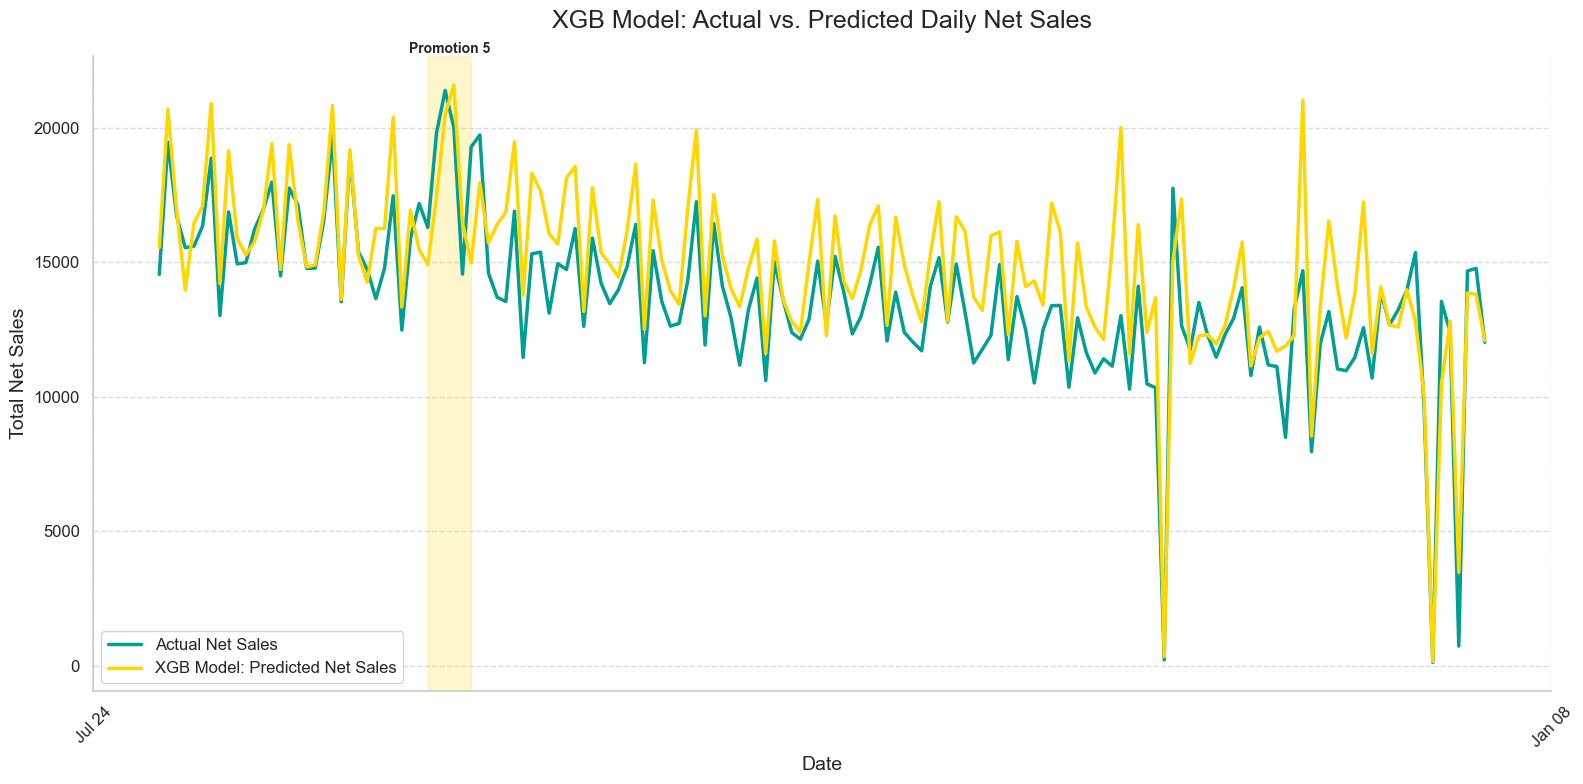

In [561]:
# Define Promotion 5 period
promotion_5 = ("2015-09-1", "2015-09-6")
promotion_5_start, promotion_5_end = pd.to_datetime(promotion_5[0]), pd.to_datetime(promotion_5[1])

# Aggregate daily actual and predicted sales
daily_comparison = partb_df.groupby("Date").agg({
    "Net_Sales_Capped": "sum",
    "XGB_Predicted_Net_Sales_Capped": "sum"
}).reset_index()

# Plot
plt.figure(figsize=(16, 8))

# Actual sales line
sns.lineplot(
    data=daily_comparison,
    x="Date",
    y="Net_Sales_Capped",
    label="Actual Net Sales",
    color="#009F93",
    linewidth=2.5
)

# Predicted sales line
sns.lineplot(
    data=daily_comparison,
    x="Date",
    y="XGB_Predicted_Net_Sales_Capped",
    label="XGB Model: Predicted Net Sales",
    color="#FFD700",
    linewidth=2.5
)

# Highlight Promotion 5
plt.axvspan(
    promotion_5_start, promotion_5_end, 
    color="#FFD700",  
    alpha=0.2
)
plt.text(
    promotion_5_start + (promotion_5_end - promotion_5_start) / 2,
    daily_comparison[["Net_Sales_Capped", "XGB_Predicted_Net_Sales_Capped"]].values.max() * 1.05,
    "Promotion 5",
    ha="center",
    va="bottom",
    fontsize=10,
    fontweight="bold"
)

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))

# Titles and labels
plt.title("XGB Model: Actual vs. Predicted Daily Net Sales", fontsize=18, pad=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Total Net Sales", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Export high-resolution image
plt.tight_layout()
plt.savefig("actual_vs_predicted_daily_netsales_promo5.png", dpi=300)
plt.show()

### **MLR Model**

#### **Prediction with MLR Model**

In [562]:
# Ensure feature alignment with training data
missing_cols = set(X_train_mlr.columns) - set(partb_model_data.columns)
for col in missing_cols:
    partb_model_data[col] = 0  # Add missing features as zero

# Reorder columns to match the model"s training features
partb_model_data = partb_model_data[X_train_mlr.columns]

# Predict using the MLR model
partb_predictions = mlr_model.predict(partb_model_data)

partb_df["MLR_Predicted_Net_Sales_Capped"] = partb_predictions

#### **Evaluation of MLR Model Prediction**

In [563]:
rmse = np.sqrt(mean_squared_error(partb_df["Net_Sales_Capped"], partb_df["MLR_Predicted_Net_Sales_Capped"]))
mae = mean_absolute_error(partb_df["Net_Sales_Capped"], partb_df["MLR_Predicted_Net_Sales_Capped"])
r2 = r2_score(partb_df["Net_Sales_Capped"], partb_df["MLR_Predicted_Net_Sales_Capped"])

print(f"\nPart-B Model with MLR:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


Part-B Model with MLR:
RMSE: 4.14
MAE: 2.22
R²: 0.12


## **Interpretation of Models" Performance**

In Part-B of the case study, the goal was to forecast the sales during Promotion 5 using the models developed in Part-A and compare these forecasts with the actual observed sales during the promotion period. Two different models—Multiple Linear Regression (MLR) and XGBoost—were applied to the new dataset to assess their predictive performance and business applicability.

After training and applying both models, the following outcomes were observed:

- The MLR model achieved an RMSE of 4.14, an MAE of 2.22, and an R² of 0.12. These results indicate that while the model captures certain patterns in the data, such as the influence of product categories and store types on sales, it still explains only a small proportion of the overall variability in sales during the promotion period. However, despite this moderate performance, the MLR model remains useful for providing general business insights and interpretable trends.

- The XGBoost model, on the other hand, performed less effectively on the Part-B dataset, with an RMSE of 4.80, an MAE of 2.59, and an R² of -0.18. This suggests that the XGBoost model struggled to generalize to the new period and context of Promotion 5, possibly due to structural differences between the Part-A training data and the Part-B data, as well as the limited explanatory power of the available features.

These results highlight a critical insight: while machine learning models like XGBoost are powerful on large datasets, they may not always translate well to new scenarios without extensive feature engineering and tuning. In contrast, the MLR model, despite its simplicity, it is more stable across different datasets and timeframes, making it more reliable for business-level forecasting and evaluation of promotion effects in this case.

Overall, the predictive power of both models remains limited. This is likely due to key challenges within the data itself, such as:

- Sparse and skewed sales distributions.

- Lack of detailed promotion information (such as which specific items were promoted or the depth of discounts).
- Structural differences between the training period and the Promotion 5 period.

Given these limitations, the MLR model will be the preferred tool for deriving insights about Promotion 5"s effects and cannibalization impact.

In [564]:
partb_df

,Date,StoreCode,ProductCode,SalesQuantity,SalesQuantity_Capped,ProductGroup1,ProductGroup2,IsPromotion,Returns,Net_Sales,Net_Sales_Capped,Week,Year,FormattedWeek,Month,Product_Category,Store_Category,XGB_Predicted_Net_Sales_Capped,MLR_Predicted_Net_Sales_Capped
0,2015-08-01,2,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast,1.285052,1.799288
1,2015-08-01,7,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast,5.012372,1.799288
2,2015-08-01,62,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast,5.012372,1.799288
3,2015-08-01,181,9,1,1,H,15,0,0,1,1,31,2015,2015- W31,2015-08,Slow,Fast,3.680754,1.799288
4,2015-08-01,6,20,1,1,A,6,0,0,1,1,31,2015,2015- W31,2015-08,Fast,Fast,4.037975,3.240559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028116,2016-01-01,340,247,5,5,A,5,0,0,5,5,53,2015,2015- W53,2016-01,Fast,Fast,2.066999,4.417027
1028117,2016-01-01,340,264,1,1,A,5,0,0,1,1,53,2015,2015- W53,2016-01,Fast,Fast,1.820733,4.417027
1028118,2016-01-01,340,292,1,1,I,10,0,0,1,1,53,2015,2015- W53,2016-01,Medium,Fast,1.284134,1.984818
1028119,2016-01-01,340,305,1,1,G,3,0,0,1,1,53,2015,2015- W53,2016-01,Medium,Fast,0.965078,2.286969


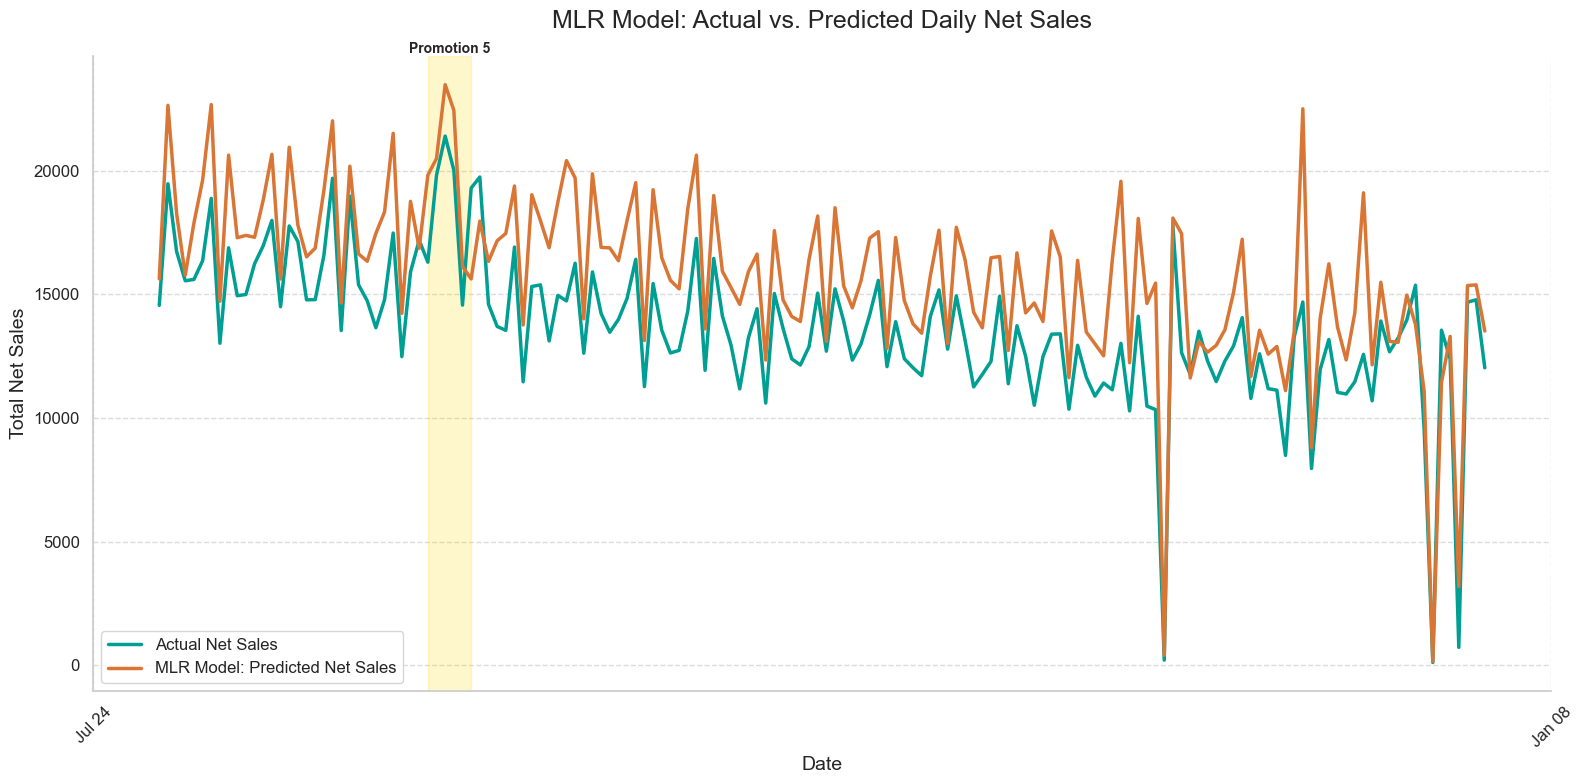

In [565]:
# Define Promotion 5 period
promotion_5 = ("2015-09-1", "2015-09-6")
promotion_5_start, promotion_5_end = pd.to_datetime(promotion_5[0]), pd.to_datetime(promotion_5[1])

# Aggregate daily actual and predicted sales
daily_comparison = partb_df.groupby("Date").agg({
    "Net_Sales_Capped": "sum",
    "MLR_Predicted_Net_Sales_Capped": "sum"
}).reset_index()

# Plot
plt.figure(figsize=(16, 8))

# Actual sales line
sns.lineplot(
    data=daily_comparison,
    x="Date",
    y="Net_Sales_Capped",
    label="Actual Net Sales",
    color="#009F93",
    linewidth=2.5
)

# Predicted sales line
sns.lineplot(
    data=daily_comparison,
    x="Date",
    y="MLR_Predicted_Net_Sales_Capped",
    label="MLR Model: Predicted Net Sales",
    color="#DA7635",
    linewidth=2.5
)

# Highlight Promotion 5
plt.axvspan(
    promotion_5_start, promotion_5_end, 
    color="#FFD700",  # Gold
    alpha=0.2
)
plt.text(
    promotion_5_start + (promotion_5_end - promotion_5_start) / 2,
    daily_comparison[["Net_Sales_Capped", "MLR_Predicted_Net_Sales_Capped"]].values.max() * 1.05,
    "Promotion 5",
    ha="center",
    va="bottom",
    fontsize=10,
    fontweight="bold"
)

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))

# Titles and labels
plt.title("MLR Model: Actual vs. Predicted Daily Net Sales", fontsize=18, pad=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Total Net Sales", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Export high-resolution image
plt.tight_layout()
plt.savefig("mlr_actual_vs_predicted_daily_netsales_promo5.png", dpi=300)
plt.show()

While the model captures the overall daily sales trend relatively well, tracking the general pattern of rises and falls, the low R² indicates it struggles to accurately reflect the full variability and magnitude of sales, particularly during high-impact periods like promotions. This is typical in volatile retail datasets where sudden spikes are hard to predict with precision.

## **Analysis**

### **Analysis Based on Forecasting of Effect of Promotion 5 on Sample Store-Product Pairs**

To analyze the forecasted effect of Promotion 5, the first step is to filter the dataset for the exact dates of the promotion period. This analysis can be conducted at multiple levels of granularity:

- Product level (individual store-product pairs)
- Product group combination level (aggregated by product families)
- Aggregate level (total sales across all products and stores).

At the product level, a random sample of store-product pairs is selected to compare the model"s predicted sales with the actual observed sales during the promotion period. This comparison helps evaluate whether the model was able to effectively capture the impact of Promotion 5 based on patterns it learned from past promotions. 

In [566]:
# Define Promotion 5 period
promo5_start = pd.to_datetime("2015-09-01")
promo5_end = pd.to_datetime("2015-09-06")

# Filter Part-B dataset for Promotion 5 period
promo5_data = partb_df[(partb_df["Date"] >= promo5_start) & (partb_df["Date"] <= promo5_end)]

# Aggregate predicted and actual sales during Promotion 5 by store and product
promo5_summary = promo5_data.groupby(["StoreCode", "ProductCode"]).agg({
    "MLR_Predicted_Net_Sales_Capped": "sum",
    "Net_Sales_Capped": "sum"
}).reset_index()    

# Rename for clarity
promo5_summary.rename(columns={
    "MLR_Predicted_Net_Sales_Capped": "Predicted_Net_Sales",
    "Net_Sales_Capped": "Actual_Net_Sales"
}, inplace=True)

# Calculate difference and absolute error
promo5_summary["Difference"] = promo5_summary["Actual_Net_Sales"] - promo5_summary["Predicted_Net_Sales"]
promo5_summary["Absolute_Error"] = promo5_summary["Difference"].abs()
promo5_summary["Percentage_Error"] = (promo5_summary["Absolute_Error"] / promo5_summary["Actual_Net_Sales"].replace(0, np.nan)) * 100

# Select a random sample of 20 product-store pairs
sample_comparison = promo5_summary.sample(n=20, random_state=42)
print(sample_comparison.head(20))


       StoreCode  ProductCode Predicted_Net_Sales  Actual_Net_Sales  \
26695        334           78            0.976956                 1   
19796        248          205            3.392383                 0   
5927          71          184            8.847807                 4   
14353        175          218           15.023623                64   
7152          86           23            1.624555                 1   
6599          79           69            2.143073                 0   
20879        263          105            2.723533                 1   
12813        155          173            0.936521                 2   
9644         115          188            4.241136                 1   
18328        232            5            4.936615                 2   
1804          22          119            0.382528                 1   
3585          44           90            1.322747                 1   
9134         109          103            2.146371                 3   
14019 

The analysis revealed a mixed performance across the sampled pairs. In some cases, the model produced estimates close to the actual sales. For instance, in Store 334 - Product 78, the prediction was remarkably accurate, with only a 2% error. However, this was not always the case. For several items, particularly those with low sales volumes, prediction errors became disproportionately large.

On the other end of the spectrum, the model occasionally predicted sales where none occurred. For example, Store 248 - Product 205 had a predicted sale of over 3 units, yet no sales were recorded. This kind of overestimation is particularly common in products with historically inconsistent sales patterns.

These results were expected due to the model"s limited capability to predict micro-level observations.

In [567]:
# Calculate average absolute error across all pairs
average_absolute_error = promo5_summary["Absolute_Error"].mean()
average_percentage_error = promo5_summary["Percentage_Error"].mean()

print(f"Average Absolute Error across all store-item pairs: {average_absolute_error:.2f}")
print(f"Average Percentage Error across all store-item pairs: {average_percentage_error:.2f}%")

Average Absolute Error across all store-item pairs: 3.43
Average Percentage Error across all store-item pairs: 124.26%


When examining the entire sample we see that the Average Absolute Error (AAE) is 3.43 units, meaning that on average, the model is off by about three to four units per product-store pair during Promotion 5.

The Average Percentage Error (APE) is 124%, which is notably high. However, it is important to recognize that percentage errors become exaggerated in cases where actual sales are extremely low. For example, if a product sold only 1 unit, even a small prediction deviation leads to an outsized percentage error.

#### **Predicted vs. Actual Impact of Promotion 5**

To better understand the effectiveness of Promotion 5, we analyzed both the actual and model-predicted uplift in sales at the product-store level. In this context, "uplift" measures how much sales increased or decreased during the promotion compared to a baseline period (we used the four weeks prior to Promotion 5 as the baseline).

In [ ]:
# Define baseline period (previous 4 weeks, excluding other promotions)
baseline_start = promo5_start - pd.Timedelta(weeks=4)
baseline_end = promo5_start - pd.Timedelta(days=1)

# Promotion 5 data already filtered
promo5_data 

# Filter Part-B dataset for the baseline period
baseline_data = partb_df[(partb_df["Date"] >= baseline_start) & (partb_df["Date"] <= baseline_end)]

# Aggregate sales for Promotion 5 period
promo5_sales = promo5_data.groupby(["StoreCode", "ProductCode"]).agg({
    "Net_Sales_Capped": "sum",
    "MLR_Predicted_Net_Sales_Capped": "sum"
}).reset_index()
promo5_sales.rename(columns={
    "Net_Sales_Capped": "Promo5_Actual_Sales",
    "MLR_Predicted_Net_Sales_Capped": "Promo5_Predicted_Sales"
}, inplace=True)

# Aggregate sales for baseline period
baseline_sales = baseline_data.groupby(["StoreCode", "ProductCode"]).agg({
    "Net_Sales_Capped": "mean",  # Average daily sales in baseline
    "MLR_Predicted_Net_Sales_Capped": "mean"
}).reset_index()
baseline_sales.rename(columns={
    "Net_Sales_Capped": "Baseline_Actual_Daily_Sales",
    "MLR_Predicted_Net_Sales_Capped": "Baseline_Predicted_Daily_Sales"
}, inplace=True)

# Merge baseline with Promotion 5 sales
comparison = promo5_sales.merge(baseline_sales, on=["StoreCode", "ProductCode"], how="left")

# Calculate uplift (total over promo period vs. baseline average scaled to 6 days)
comparison["Actual_Uplift"] = comparison["Promo5_Actual_Sales"] - (comparison["Baseline_Actual_Daily_Sales"] * 6)
comparison["Predicted_Uplift"] = comparison["Promo5_Predicted_Sales"] - (comparison["Baseline_Predicted_Daily_Sales"] * 6)

# Difference between actual and predicted uplift
comparison["Uplift_Error"] = comparison["Actual_Uplift"] - comparison["Predicted_Uplift"]

# Overall average uplift to report
avg_actual_uplift = comparison["Actual_Uplift"].mean()
avg_predicted_uplift = comparison["Predicted_Uplift"].mean()
avg_uplift_error = comparison["Uplift_Error"].mean()

print(f"Average Actual Uplift/Lowered during Promotion 5: {avg_actual_uplift:.2f}")
print(f"Average Predicted Uplift/Lowered during Promotion 5: {avg_predicted_uplift:.2f}")
print(f"Average Uplift/Lowered Error (Actual - Predicted): {avg_uplift_error:.2f}")


Average Actual Uplift/Lowered during Promotion 5: -7.80
Average Predicted Uplift/Lowered during Promotion 5: -9.25
Average Uplift/Lowered Error (Actual - Predicted): 1.45


In [ ]:
# Show top store-product pairs with the highest actual uplift
comparison.sort_values(by="Actual_Uplift", ascending=False).head(10)

,StoreCode,ProductCode,Promo5_Actual_Sales,Promo5_Predicted_Sales,Baseline_Actual_Daily_Sales,Baseline_Predicted_Daily_Sales,Actual_Uplift,Predicted_Uplift,Uplift_Error
19996,250,167,133,38.857158,6.666667,7.02772,93.000000,-3.309162,96.309162
4378,55,218,133,25.049046,7.818182,3.792072,86.090909,2.296615,83.794294
24425,305,218,146,29.601125,10.761905,3.69291,81.428571,7.443668,73.984903
7231,86,221,111,20.726385,6.000000,3.243297,75.000000,1.266604,73.733396
24428,305,221,88,24.017675,2.882353,3.717467,70.705882,1.712874,68.993009
26270,330,169,82,30.743177,2.428571,6.997676,67.428571,-11.242878,78.67145
5264,64,221,79,29.605875,2.000000,3.706571,67.000000,7.366447,59.633553
717,7,218,130,29.607191,10.529412,3.735465,66.823529,7.194402,59.629128
2901,36,221,76,15.837089,1.750000,3.72487,65.500000,-6.512133,72.012133
21514,270,218,114,19.395646,8.285714,3.818865,64.285714,-3.517543,67.803257


Promotion 5 did not increase sales at the product-store level on average. Surprisingly, both actual and predicted uplifts are negative, meaning that during Promotion 5, most product-store pairs sold fewer units compared to the previous month, despite the active promotion. This suggests that the Promotion 5 either:

- Failed to generate the desired demand, or
- Was overshadowed by other factors, such as seasonality, saturation, or perhaps competitive pressures.

However, while the aggregate uplift was captured reasonably well, this does not necessarily mean the model got every individual store-product pair correct. As shown in the earlier error analysis, discrepancies exist at the micro level, especially for items with low or unpredictable sales.

While the model provides a useful baseline for forecasting, its performance during Promotion 5 suggests it should be used with caution at the micro (store-item) level. For operational purposes, the model can guide expectations on overall promotional impact, but it may fall short in precisely forecasting demand for every single product-store pair. 

### **Measure the Cannibalization Impact During Promotion 5**

Since we have both actual and predicted sales for Promotion 5 from the model, we can analyze cannibalization based on predictions and then compare it directly to the actual cannibalization.

In [ ]:
# Ensure "ProductGroup_Combo" exists
partb_df["ProductGroup_Combo"] = partb_df["ProductGroup1"].astype(str) + "_" + partb_df["ProductGroup2"].astype(str)

# Promotion 5 end and start dates already defined
promo5_start, promo5_end

# Pre-promotion baseline period (last 4 weeks)
pre_promo5_start = promo5_start - pd.Timedelta(weeks=4)
pre_promo5_end = promo5_start - pd.Timedelta(days=1)

# Ensure filtering the data for periods to avoid data leakage
promo5_data = partb_df[(partb_df["Date"] >= promo5_start) & (partb_df["Date"] <= promo5_end)]
pre_promo5_data = partb_df[(partb_df["Date"] >= pre_promo5_start) & (partb_df["Date"] <= pre_promo5_end)]

# Pre-promotion average sales (actual) to compare with Promotion 5
pre_promo5_avg = pre_promo5_data.groupby(["ProductGroup_Combo", "ProductCode"])["Net_Sales_Capped"].mean().reset_index()
pre_promo5_avg.rename(columns={"Net_Sales_Capped": "Pre_Promo_Avg_Sales"}, inplace=True)

# Actual and predicted average sales during Promotion 5 to compare
promo5_avg_actual = promo5_data.groupby(["ProductGroup_Combo", "ProductCode"])["Net_Sales_Capped"].mean().reset_index()
promo5_avg_actual.rename(columns={"Net_Sales_Capped": "Promo5_Avg_Actual_Sales"}, inplace=True)

promo5_avg_predicted = promo5_data.groupby(["ProductGroup_Combo", "ProductCode"])["MLR_Predicted_Net_Sales_Capped"].mean().reset_index()
promo5_avg_predicted.rename(columns={"MLR_Predicted_Net_Sales_Capped": "Promo5_Avg_Predicted_Sales"}, inplace=True)

# Merge actual and predicted sales with pre-promo baseline to compare
comparison = pre_promo5_avg.merge(promo5_avg_actual, on=["ProductGroup_Combo", "ProductCode"], how="inner")
comparison = comparison.merge(promo5_avg_predicted, on=["ProductGroup_Combo", "ProductCode"], how="inner")

# "To accurately calculate percentage changes in sales during Promotion 5 and avoid division errors, 
# we excluded products that had zero sales in the pre-promotion period. 
# These products lack a baseline for meaningful comparison, 
# and including them would distort uplift and cannibalization analyses."

# Remove rows where Pre_Promo_Avg_Sales == 0 to avoid division by zero
comparison = comparison[comparison["Pre_Promo_Avg_Sales"] > 0].copy()

# Calculate percentage change (uplift or drop) vs pre-promo baseline for actual and predicted sales
comparison["Actual_% Change"] = ((comparison["Promo5_Avg_Actual_Sales"] - comparison["Pre_Promo_Avg_Sales"]) / comparison["Pre_Promo_Avg_Sales"]) * 100
comparison["Predicted_% Change"] = ((comparison["Promo5_Avg_Predicted_Sales"] - comparison["Pre_Promo_Avg_Sales"]) / comparison["Pre_Promo_Avg_Sales"]) * 100
comparison["Difference_% Change"] = comparison["Actual_% Change"] - comparison["Predicted_% Change"]

# Add Product Category for better interpretation
comparison = comparison.merge(
    partb_df[["ProductCode", "Product_Category"]].drop_duplicates(),
    on="ProductCode",
    how="left"
)

# Detect cannibalization: combos with mixed behavior (some products up, some down)
mixed_behavior_combos_promo5 = []
for combo, group in comparison.groupby("ProductGroup_Combo"):
    if (group["Actual_% Change"] > 0).any() and (group["Actual_% Change"] < 0).any():
        mixed_behavior_combos_promo5.append(combo)

# Extract cannibalization cases
cannibalization_cases_promo5 = comparison[comparison["ProductGroup_Combo"].isin(mixed_behavior_combos_promo5)]

# View top cannibalized items (actual vs predicted)
top_cannibalized_promo5 = cannibalization_cases_promo5.sort_values("Actual_% Change").head(20)
print(top_cannibalized_promo5)

    ProductGroup_Combo  ProductCode  Pre_Promo_Avg_Sales  \
19                 A_5          109             0.450000   
127               E_13           53             0.818182   
79                 A_6           61             1.164179   
197               G_25          124             5.166667   
80                 A_6           62             1.476190   
244               H_19           74             0.777778   
245               H_19           75             0.827586   
115               D_29          132             1.000000   
211                G_3          308             1.787645   
116               D_29          133             1.333333   
161               F_23          258             1.273973   
191               G_24          224             1.391304   
168                F_9          178             2.932018   
249               I_10          162             1.037037   
20                 A_5          110             0.285714   
277                J_8          139     

The analysis of Promotion 5 reveals notable cannibalization effects within several product group combinations, reflected by sharp declines in actual sales during the promotion period. By comparing the average sales during the 4 weeks prior to Promotion 5 with sales during the promotion, we observed significant decreases in many products" sales, which suggests that the promotion of certain items may have negatively impacted the sales of others in the same or related groups.

- **Severe Cannibalization Detected.** The most extreme cases show products with near-total sales collapse during Promotion 5.
    - Product 109 (A_5) experienced a -100% actual sales drop, completely losing its sales volume during the promotion, even though the model predicted a 408% increase, highlighting a significant mismatch.
    - Similarly, Product 53 (E_13) and Product 61 (A_6) faced -85% and -81% actual declines, respectively.

    These findings imply that some products were heavily cannibalized during Promotion 5, likely due to aggressive promotion of alternative products within the same combinations.

- **Model Limitations on Cannibalization Detection.** The model struggled to predict these cannibalization effects accurately.
    - For example, while Product 109 (A_5) dropped to zero sales, the model anticipated a large positive increase, missing the cannibalization signal.
    - Product 110 (A_5), which had a -12.5% actual drop, was predicted to increase by 709%, showing another large discrepancy.
    
    This suggests that historical promotion behavior and inter-product dynamics might not have been fully captured by the model, particularly for competitive products within the same group.

- **Mixed Behavior Across Product Groups** Certain product groups, such as A_5, D_29, and F_2, have multiple products showing substantial declines, which is a classic cannibalization pattern.

    - In ProductGroup_Combo A_5, several products (109, 110, 246, 247) showed notable sales drops.
    - In ProductGroup_Combo D_29, products 132 and 133 both fell by around -25% to -50%.

    These mixed results confirm that intra-group competition was at play during the promotion, where promoting certain products reduced the demand for others in the same category.

- **Product Category Sensitivity** Cannibalization hits were spread across Slow, Medium, and Fast product categories:
    - Slow products like Product 109 (A_5) and Product 53 (E_13) showed severe cannibalization.
    - Medium products, such as Product 61 (A_6) and Product 133 (D_29), also faced substantial declines.
    - Fast products, such as Product 178 (F_9), saw moderate but notable losses (-17%).

    This indicates that cannibalization risk is not confined to high-selling Fast products, but also threatens Slow and Medium products during intensive promotions.


